## Celligner 2: trials

### setting up

In [2]:
import pandas as pd

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np

import celligner2

Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [288]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

### some late cleanups

In [289]:
# removing ultra rare samples

In [290]:
MINEXAMPLE=4

In [291]:
todrop = []
for k, v in Counter(dataset.obs["disease_type"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["disease_type"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

endometrial_squamous
glassy_cell_carcinoma
breast_adenocarcinoma
ovary_carcinoma
thyroid_squamous
unspecified_leukemia
b-cell,_non-hodgkins,_burkitts
cervical_adenocarcinoma
uterine_sarcoma
teratoma
mullerian_carcinoma
sccoht
merkel_cell_carcinoma
thyroid_sarcoma
duodenal_adenocarcinoma
b-cell
clear_cell_carcinoma
krukenberg_tumor
chondrosarcoma
choriocarcinoma
mixed_germ_cell
endometrial_adenosquamous
endometrial_stromal_sarcoma
thymic_carcinoma
brenner_tumor
atl
prostate_small_cell
endocrine
prostate_hyperplasia
lung_carcinoid
angiosarcoma
acinar_cell_carcinoma
melanotic_neuroectodermal_tumor
gliomatosis_cerebri
nut_midline_carcinoma
myoepithelial_carcinoma
myeloid_neoplasm_nos
neurofibroma
nasopharyngeal_carcinoma
perivascular_epithelioid_cell_neoplasms
clear_cell_carcinoma_of_cervix
epithelioid_hemangioendothelioma
juvenile_myelomonocytic_leukemia
alveolar_sarcoma
pleuropulmonary_blastoma
craniopharyngioma
adrenocortical_adenoma
rosette_forming_glioneuronal_tumor
neuroendocrine_car

In [292]:
todrop = []
for k, v in Counter(dataset.obs["lineage"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["lineage"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

fibroblast_upper_aerodigestive
fibroblast_lymphocyte
fibroblast_colorectal
fibroblast_soft_tissue
fibroblast_urinary_tract


In [293]:
for val in ['dataset','ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

dataset {'met500', 'ccle', 'hcmi', 'cclf', 'pediatric_PDX', 'tcga'}
ends {'paired end'}
reference {'hg19', 'hg38'}
method {'bulk'}
sequencer {'Illlumina TruSeq', 'Illumina HiSeq 2000', 'Illumina HiSeq 4000'}


In [194]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [294]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [295]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [296]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

we can use estimation for the missing values in the conditional dataset

In [297]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & dataset.obs['dataset'].isin(['hcmi','cclf']), "cell_format"] = ["2D","3D","3D","3D","3D"]# = evaluator.adata_latent.obs.loc[dataset.obs.loc[(dataset.obs['cell_format']=='U')].index, 'cell_format_pred']

In [298]:
print(set(dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset))
dataset.obs['cell_format'] = dataset.obs['cell_format'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [299]:
print(set(dataset.obs.loc[(dataset.obs['conservation']=='U')].dataset))
dataset.obs['conservation'] = dataset.obs['conservation'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [300]:
dataset.obs.loc[dataset.obs.sample_type=='model', 'contamination'] = 'none'

In [301]:
dataset.obs.morphology = dataset.obs.morphology.cat.add_categories('none')
dataset.obs.loc[dataset.obs.sample_type!='model', 'morphology'] = 'none'

In [193]:
low_nan_genes = np.isnan(dataset.X).sum(0)<len(dataset.X)*0.2
loc = np.argsort(np.nanvar(dataset.X[:,low_nan_genes], 0))[-3000:]
dataset = AnnData(dataset.X[:,low_nan_genes][:,loc], dataset.obs, dataset.var[low_nan_genes].iloc[loc])

In [18]:
(np.isnan(dataset.X).sum(0)>3000).sum()

0

In [19]:
cols = ['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

In [20]:
pred = ['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt' , 'cell_type', 'morphology', 'ethnicity', 'instability', 'hasebv', 'base_media', 'stage','passage_number','contamination']

In [82]:
dataset.obs.conservation

sample_id
ACH-001113               fresh
ACH-001289               fresh
ACH-001339               fresh
ACH-001538               fresh
ACH-000242               fresh
                         ...  
HCM-BROD-0036-C41-85A    fresh
HCM-BROD-0025-C16-85A    fresh
HCM-BROD-0002-C71-85A    fresh
HCM-BROD-0043-C16-85B    fresh
HCM-CSHL-0065-C20-85A    fresh
Name: conservation, Length: 14926, dtype: category
Categories (3, object): ['none', 'fresh', 'frozen']

## runs

### initial model run (default?) MMD on Z

In [37]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 27
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 320 

Decoder Architecture:
	First Layer in, out and cond:  16 128 27
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |███-----------------| 19.3%  - val_loss: 8043.6398763021 - val_recon_loss: 4780.6340006510 - val_kl_loss: 65.5215560913 - val_class_ce_loss: 395.9164594650 - val_mmd_loss: 2867.07090861004
ADJUSTED LR
 |████----------------| 21.7%  - val_loss: 7864.9990234375 - val_recon_loss: 4796.4401041667 - val_kl_loss: 65.5728858948 - val_class_ce_loss: 368.4650513093 - val_mmd_loss: 2700.0728800456
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 43


In [40]:
cl2.save('./temp/model', overwrite=True)

In [37]:
# doesn't work, the model then outputs nans as latent factors.
cl2 = celligner2.CELLIGNER2.load(dir_path='./temp/model', adata=dataset)

AnnData object with n_obs × n_vars = 15064 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'celligner2_size_factors'


TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [38]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

we have a certain distribution of passage numbers only based on CCLF samples. looking at CCLE we expect high passages considerign they are historical cell lines. this is what we get

In [103]:
Counter(obs[(obs['passage_number']!="U")]['passage_number'])

Counter({'none': 12236, 'verylow': 6, 'medium': 39, 'high': 31, 'low': 14})

In [156]:
obs = evaluator.adata_latent.obs
Counter(obs[(obs['passage_number']=="U") & (obs.dataset=="ccle")]['passage_number_pred'])

Counter({'high': 642, 'medium': 667, 'verylow': 26, 'low': 13})

then it doesn't make any sense on tcga (we would expect low if anything else)

In [155]:
Counter(obs[(obs['passage_number']=="none") & (obs.dataset=="tcga")]['passage_number_pred'])

NameError: name 'obs' is not defined

In [39]:
evaluator.get_class_quality(classes=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt', 'cell_type', 'base_media', 'morphology', 'ethnicity', 'instability', 'hasebv', 'passage_number', 'contamination', 'stage'])

lineage
all predicted categories:  {'gastric', 'kidney', 'lymphocyte', 'pancreas', 'plasma_cell', 'fibroblast_bone', 'breast', 'uterus', 'fibroblast_skin', 'gall_bladder', 'prostate', 'skin', 'cervix', 'soft_tissue', 'blood', 'thyroid', 'peripheral_nervous_system', 'esophagus', 'oral', 'adrenal', 'bone', 'bladder', 'central_nervous_system', 'eye', 'upper_aerodigestive', 'bile_duct', 'ovary', 'ampulla of vater', 'liver', 'germ_cell', 'lung', 'testis', 'colon', 'brain', 'stomach'}
accuracy:  0.928644171362618
F1 Score: 0.69


collection_site
all predicted categories:  {'pancreatic_tail', 'peritoneal', 'endometrium', 'kidney', 'pancreas', 'large_intestine', 'heart', 'ileum', 'lymph_node', 'bone_marrow', 'breast', 'post_mortem_blood', 'haematopoietic_and_lymphoid_tissue', 'sigmoid_colon', 'autonomic_ganglia', 'head_and_neck_region', 'cerebellum', 'prostate', 'skin', 'upper_aerodigestive_tract', 'biliatract', 'fibroblast', 'pleura', 'soft_tissue', 'posterior_mediastil_(mediastinum)', 'thyro

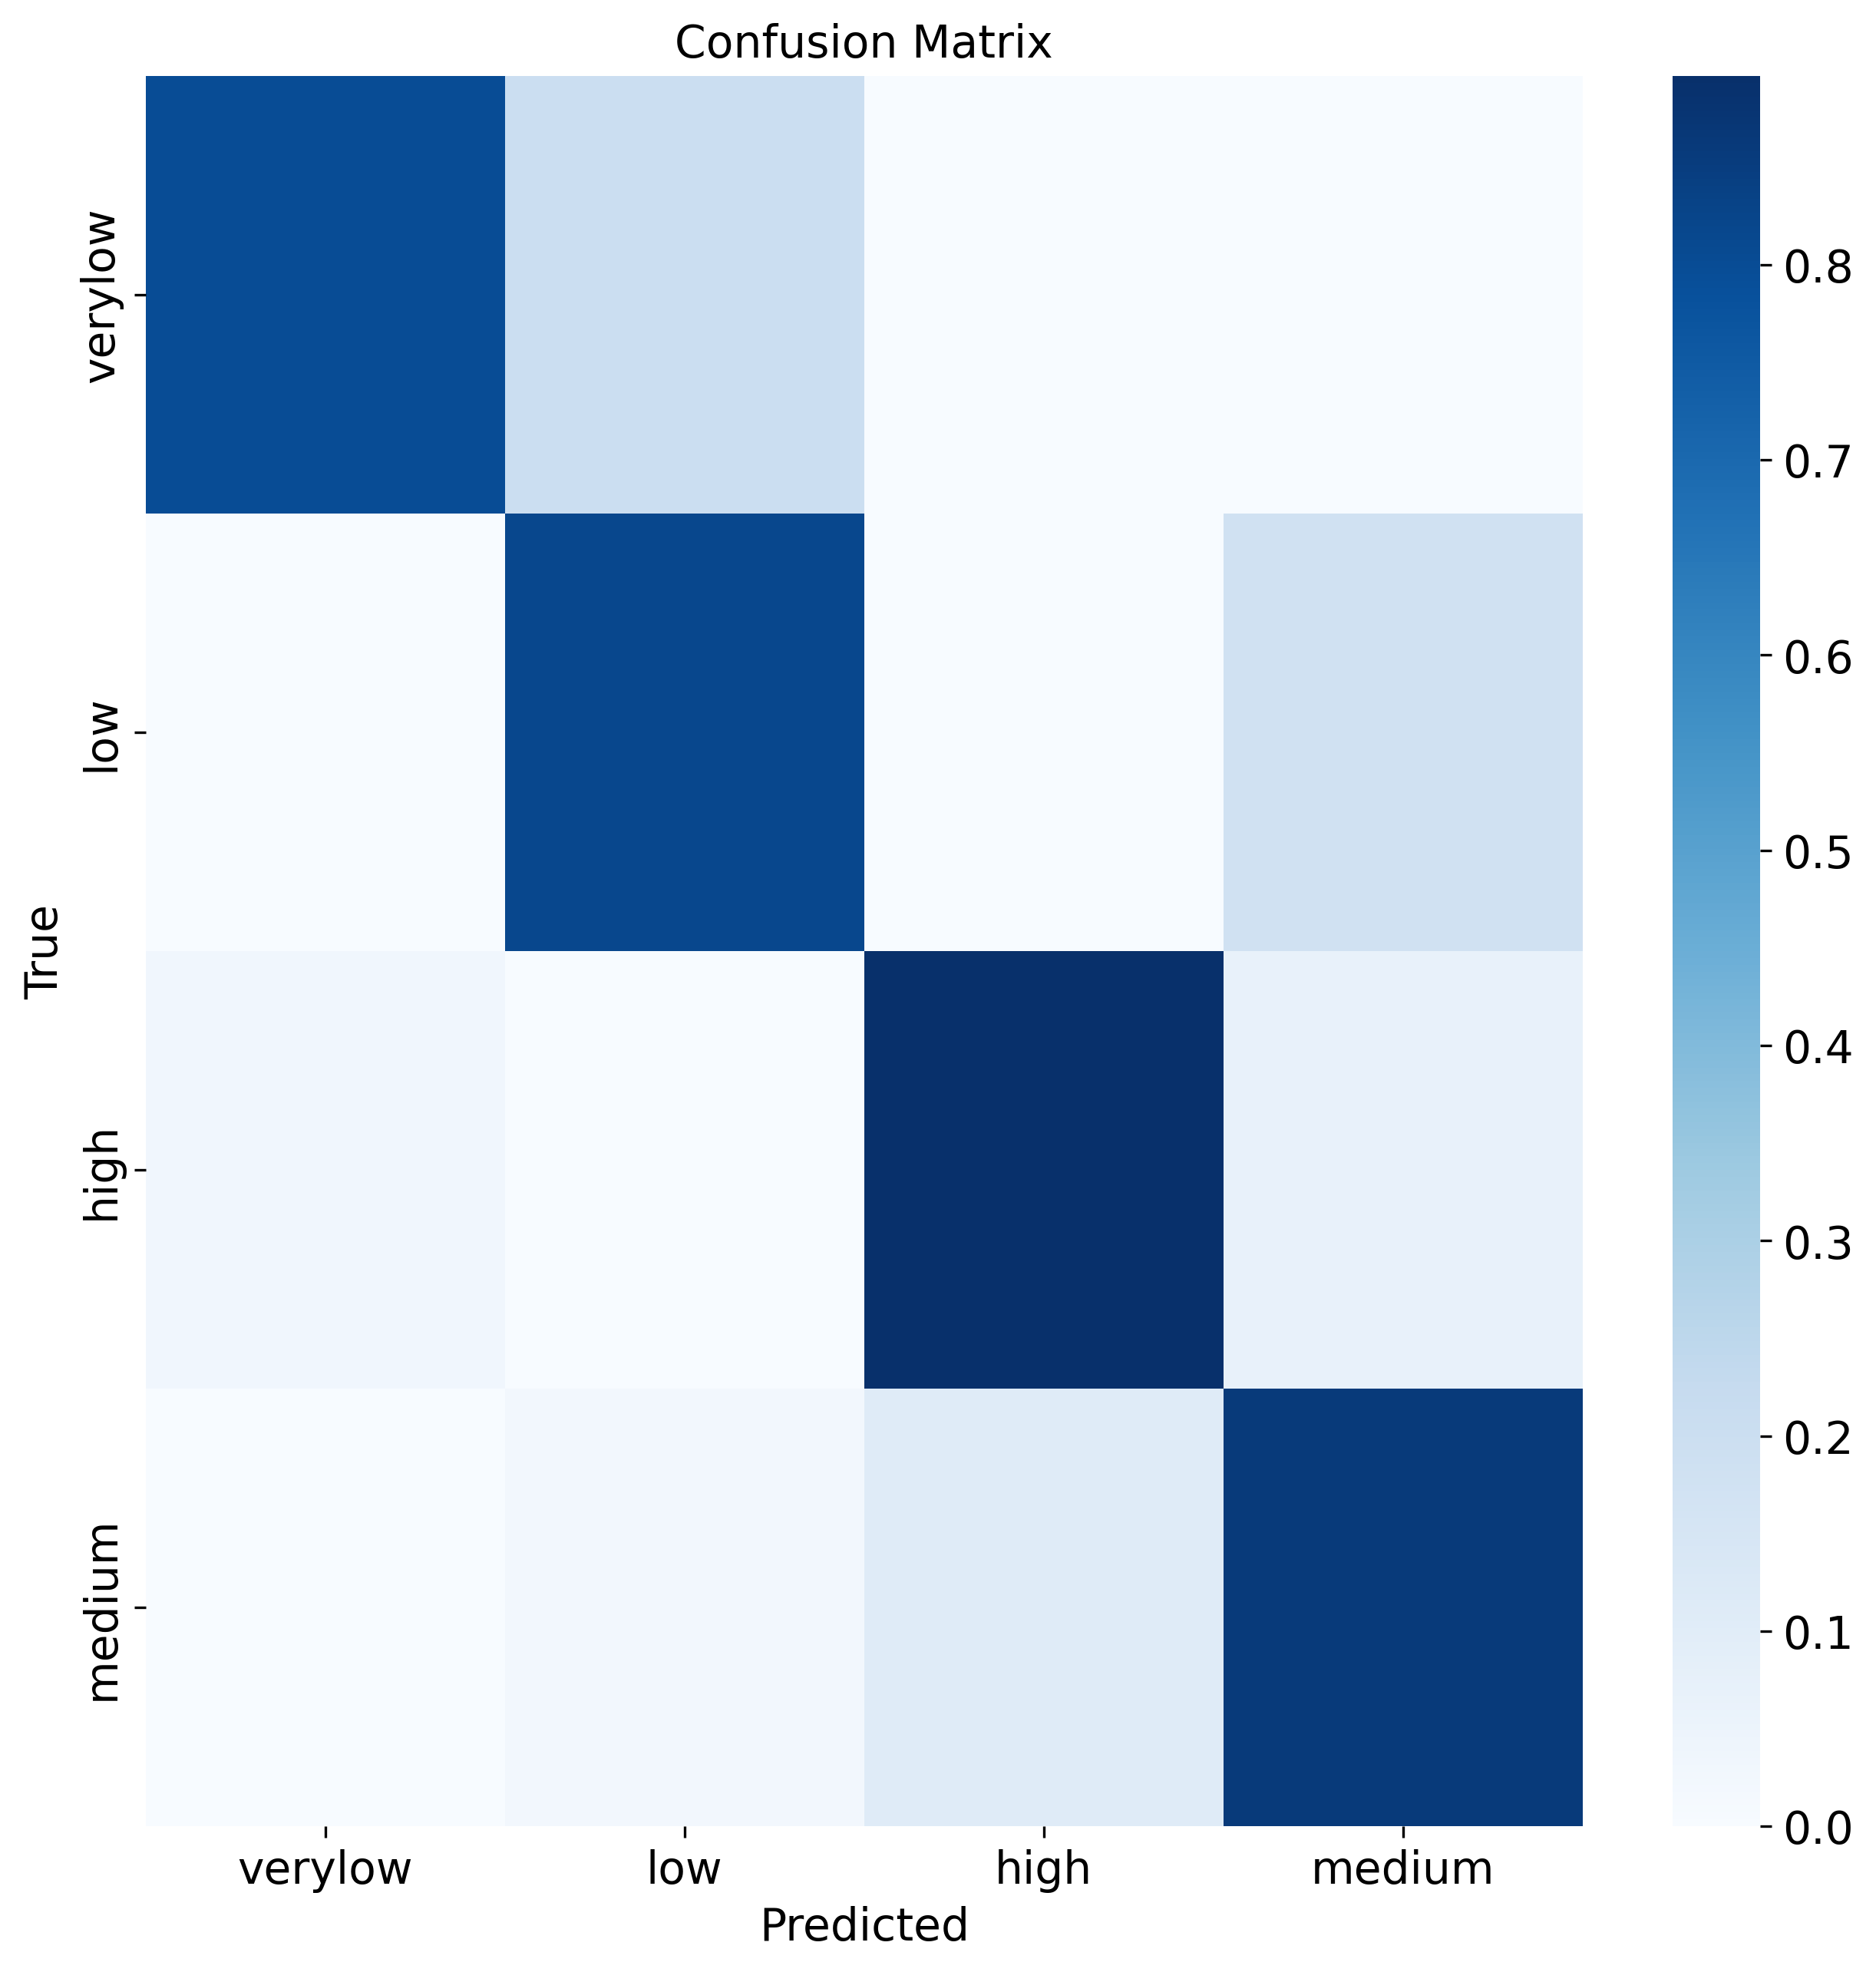

In [24]:
conf = evaluator.getconfusionMatrix(on="passage_number", only=None, figsize=(10,10))

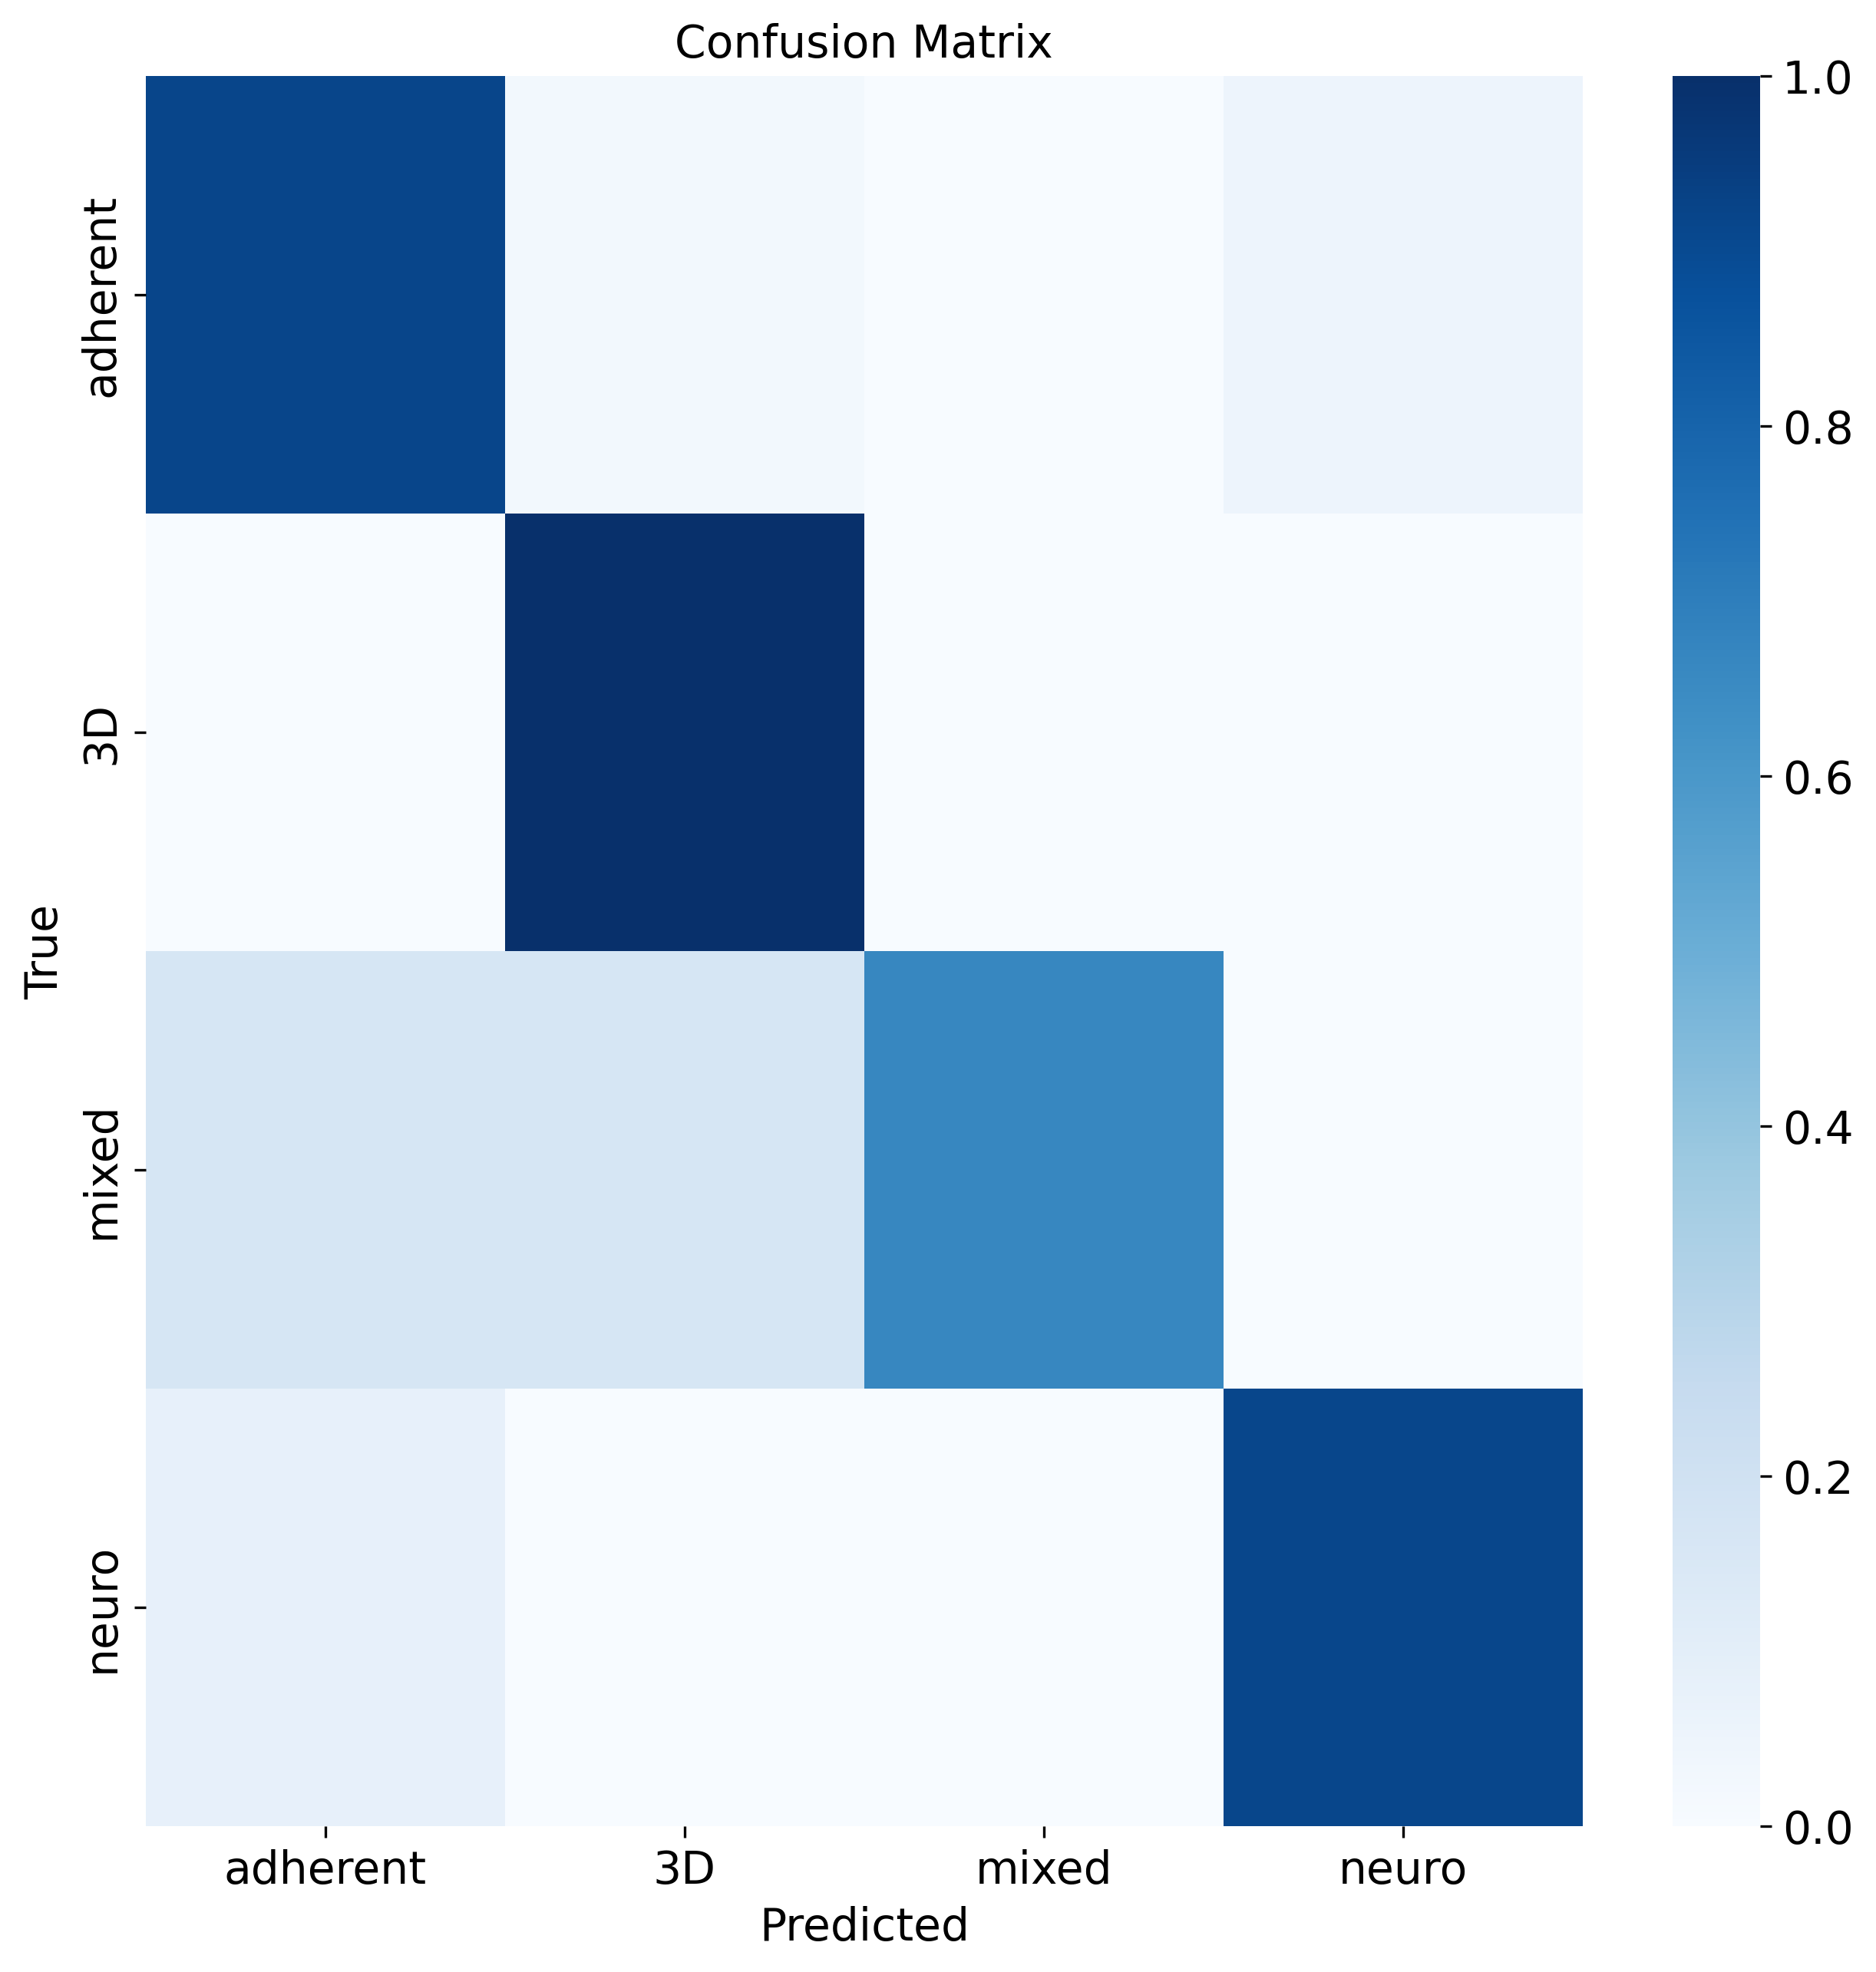

In [151]:
conf = evaluator.getconfusionMatrix(on="morphology", only=None)

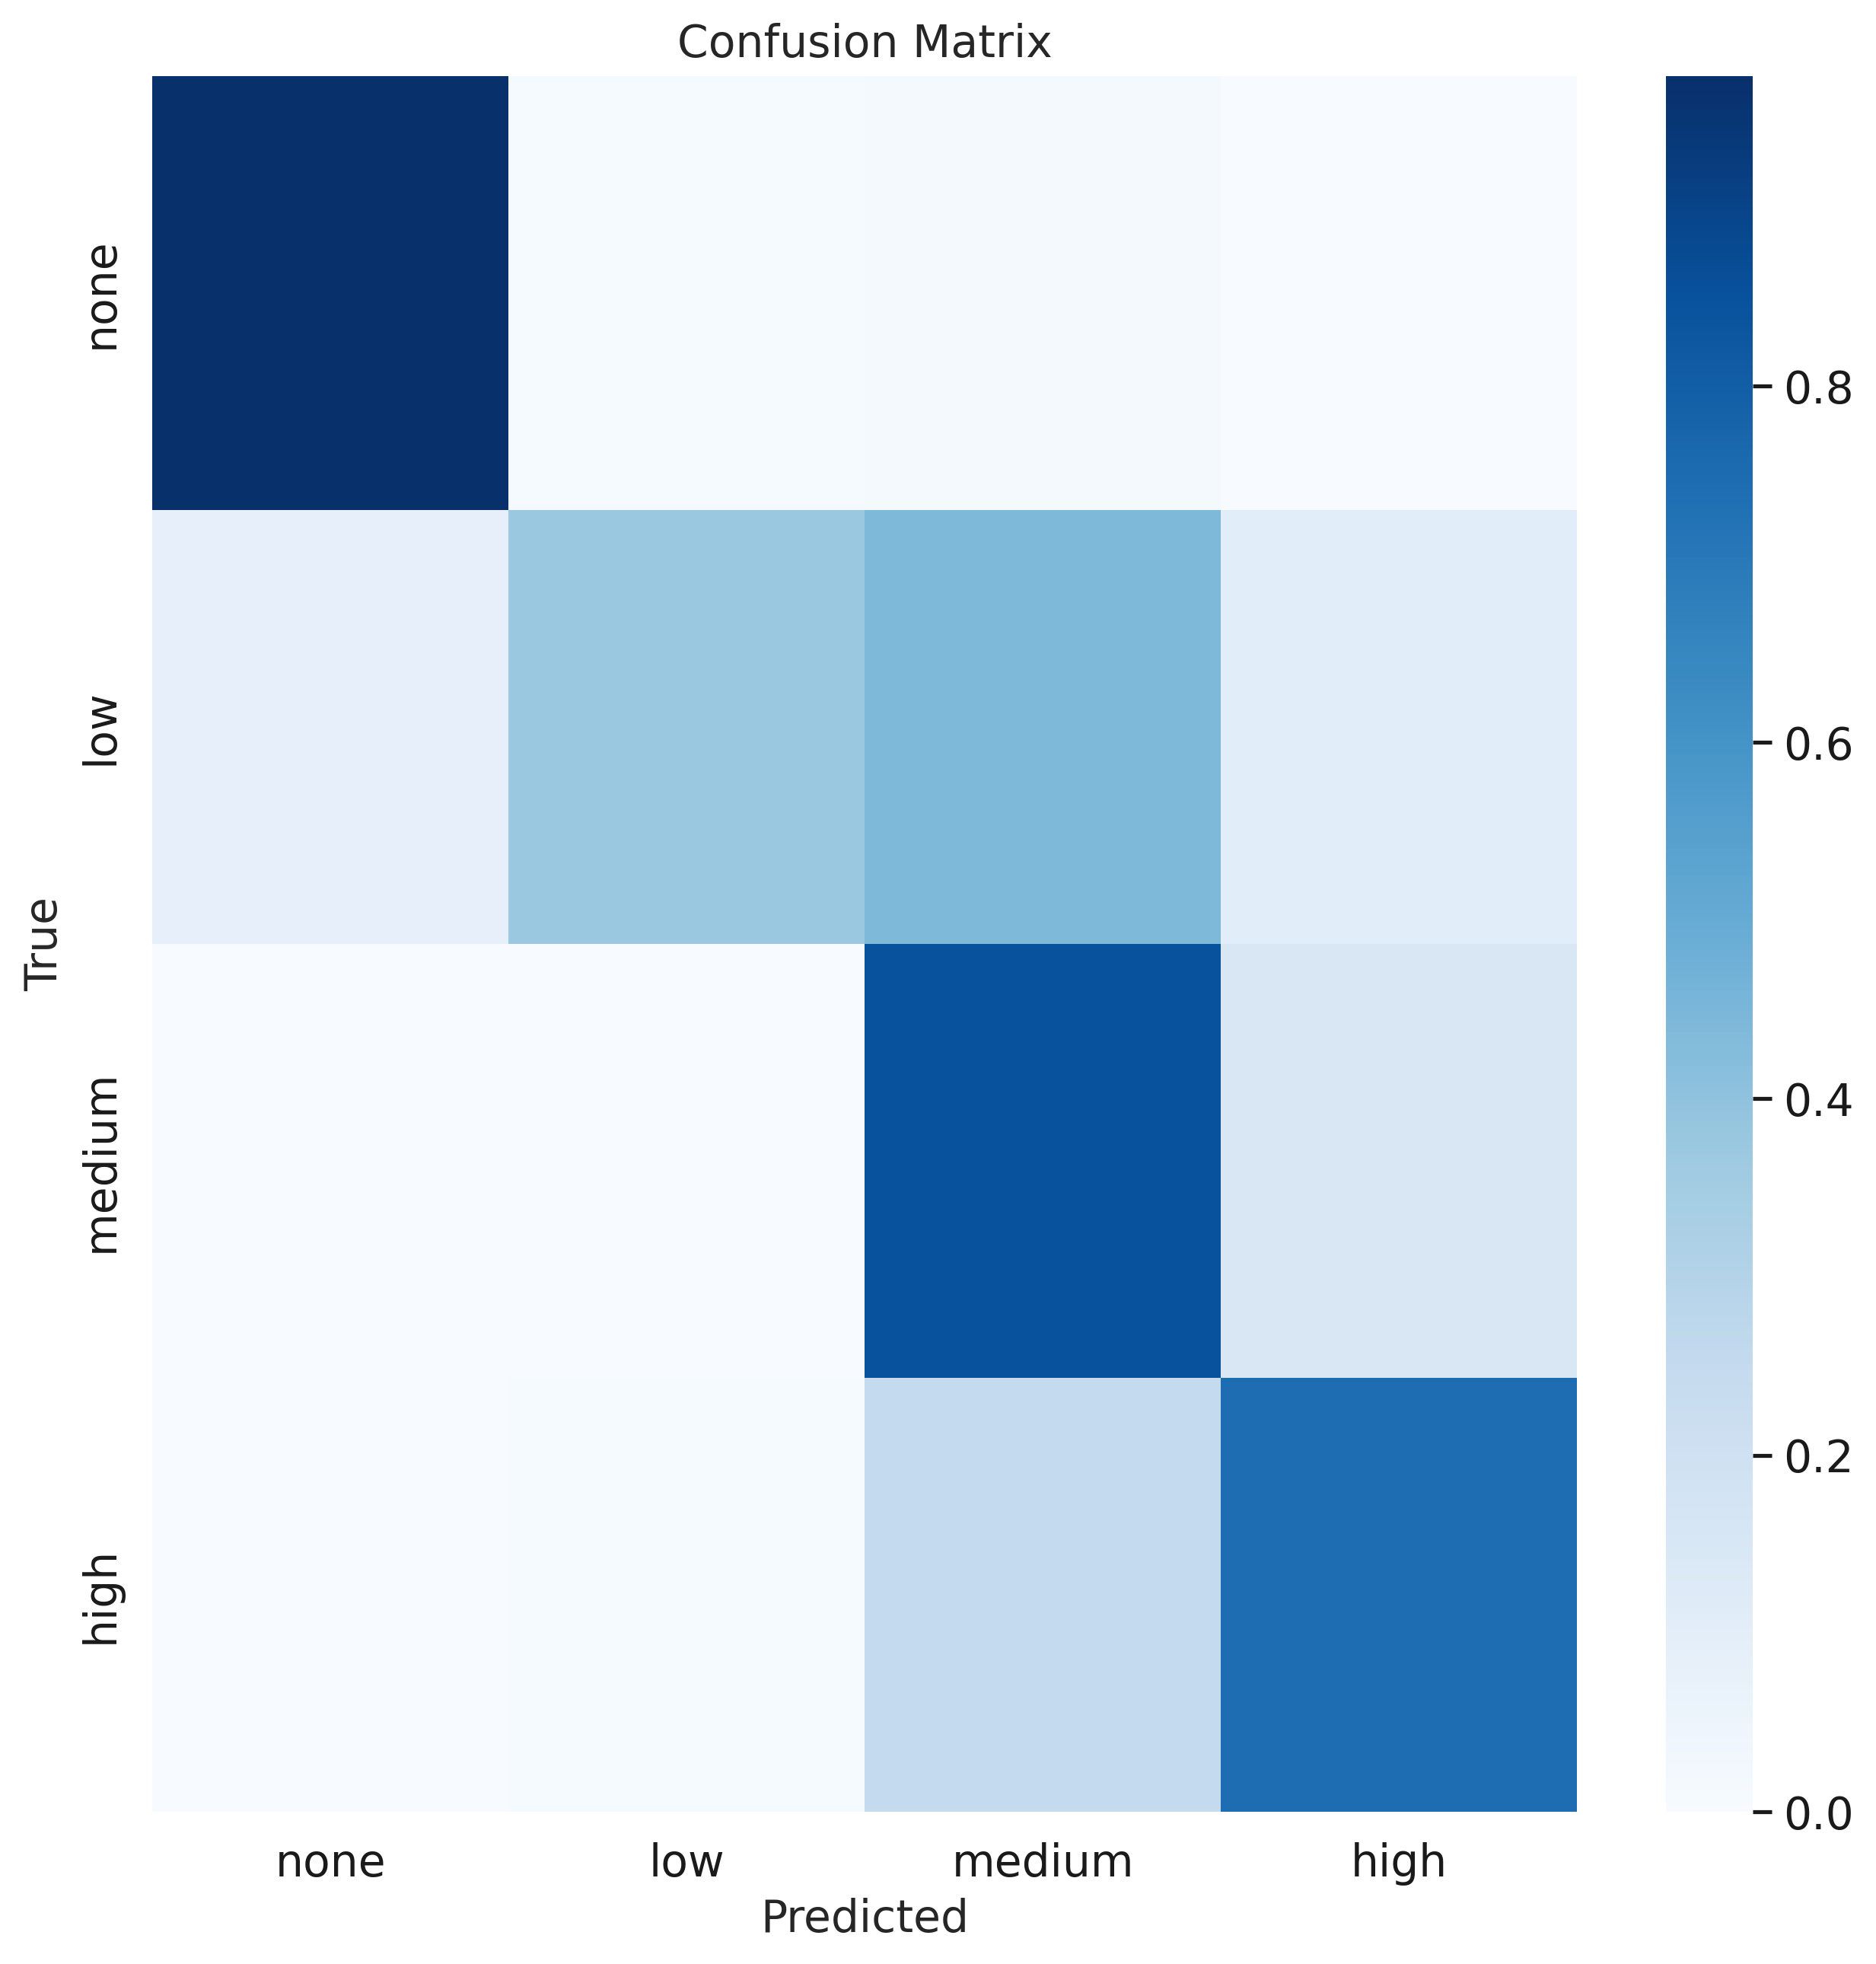

In [128]:
conf = evaluator.getconfusionMatrix(on="contamination", only=None)

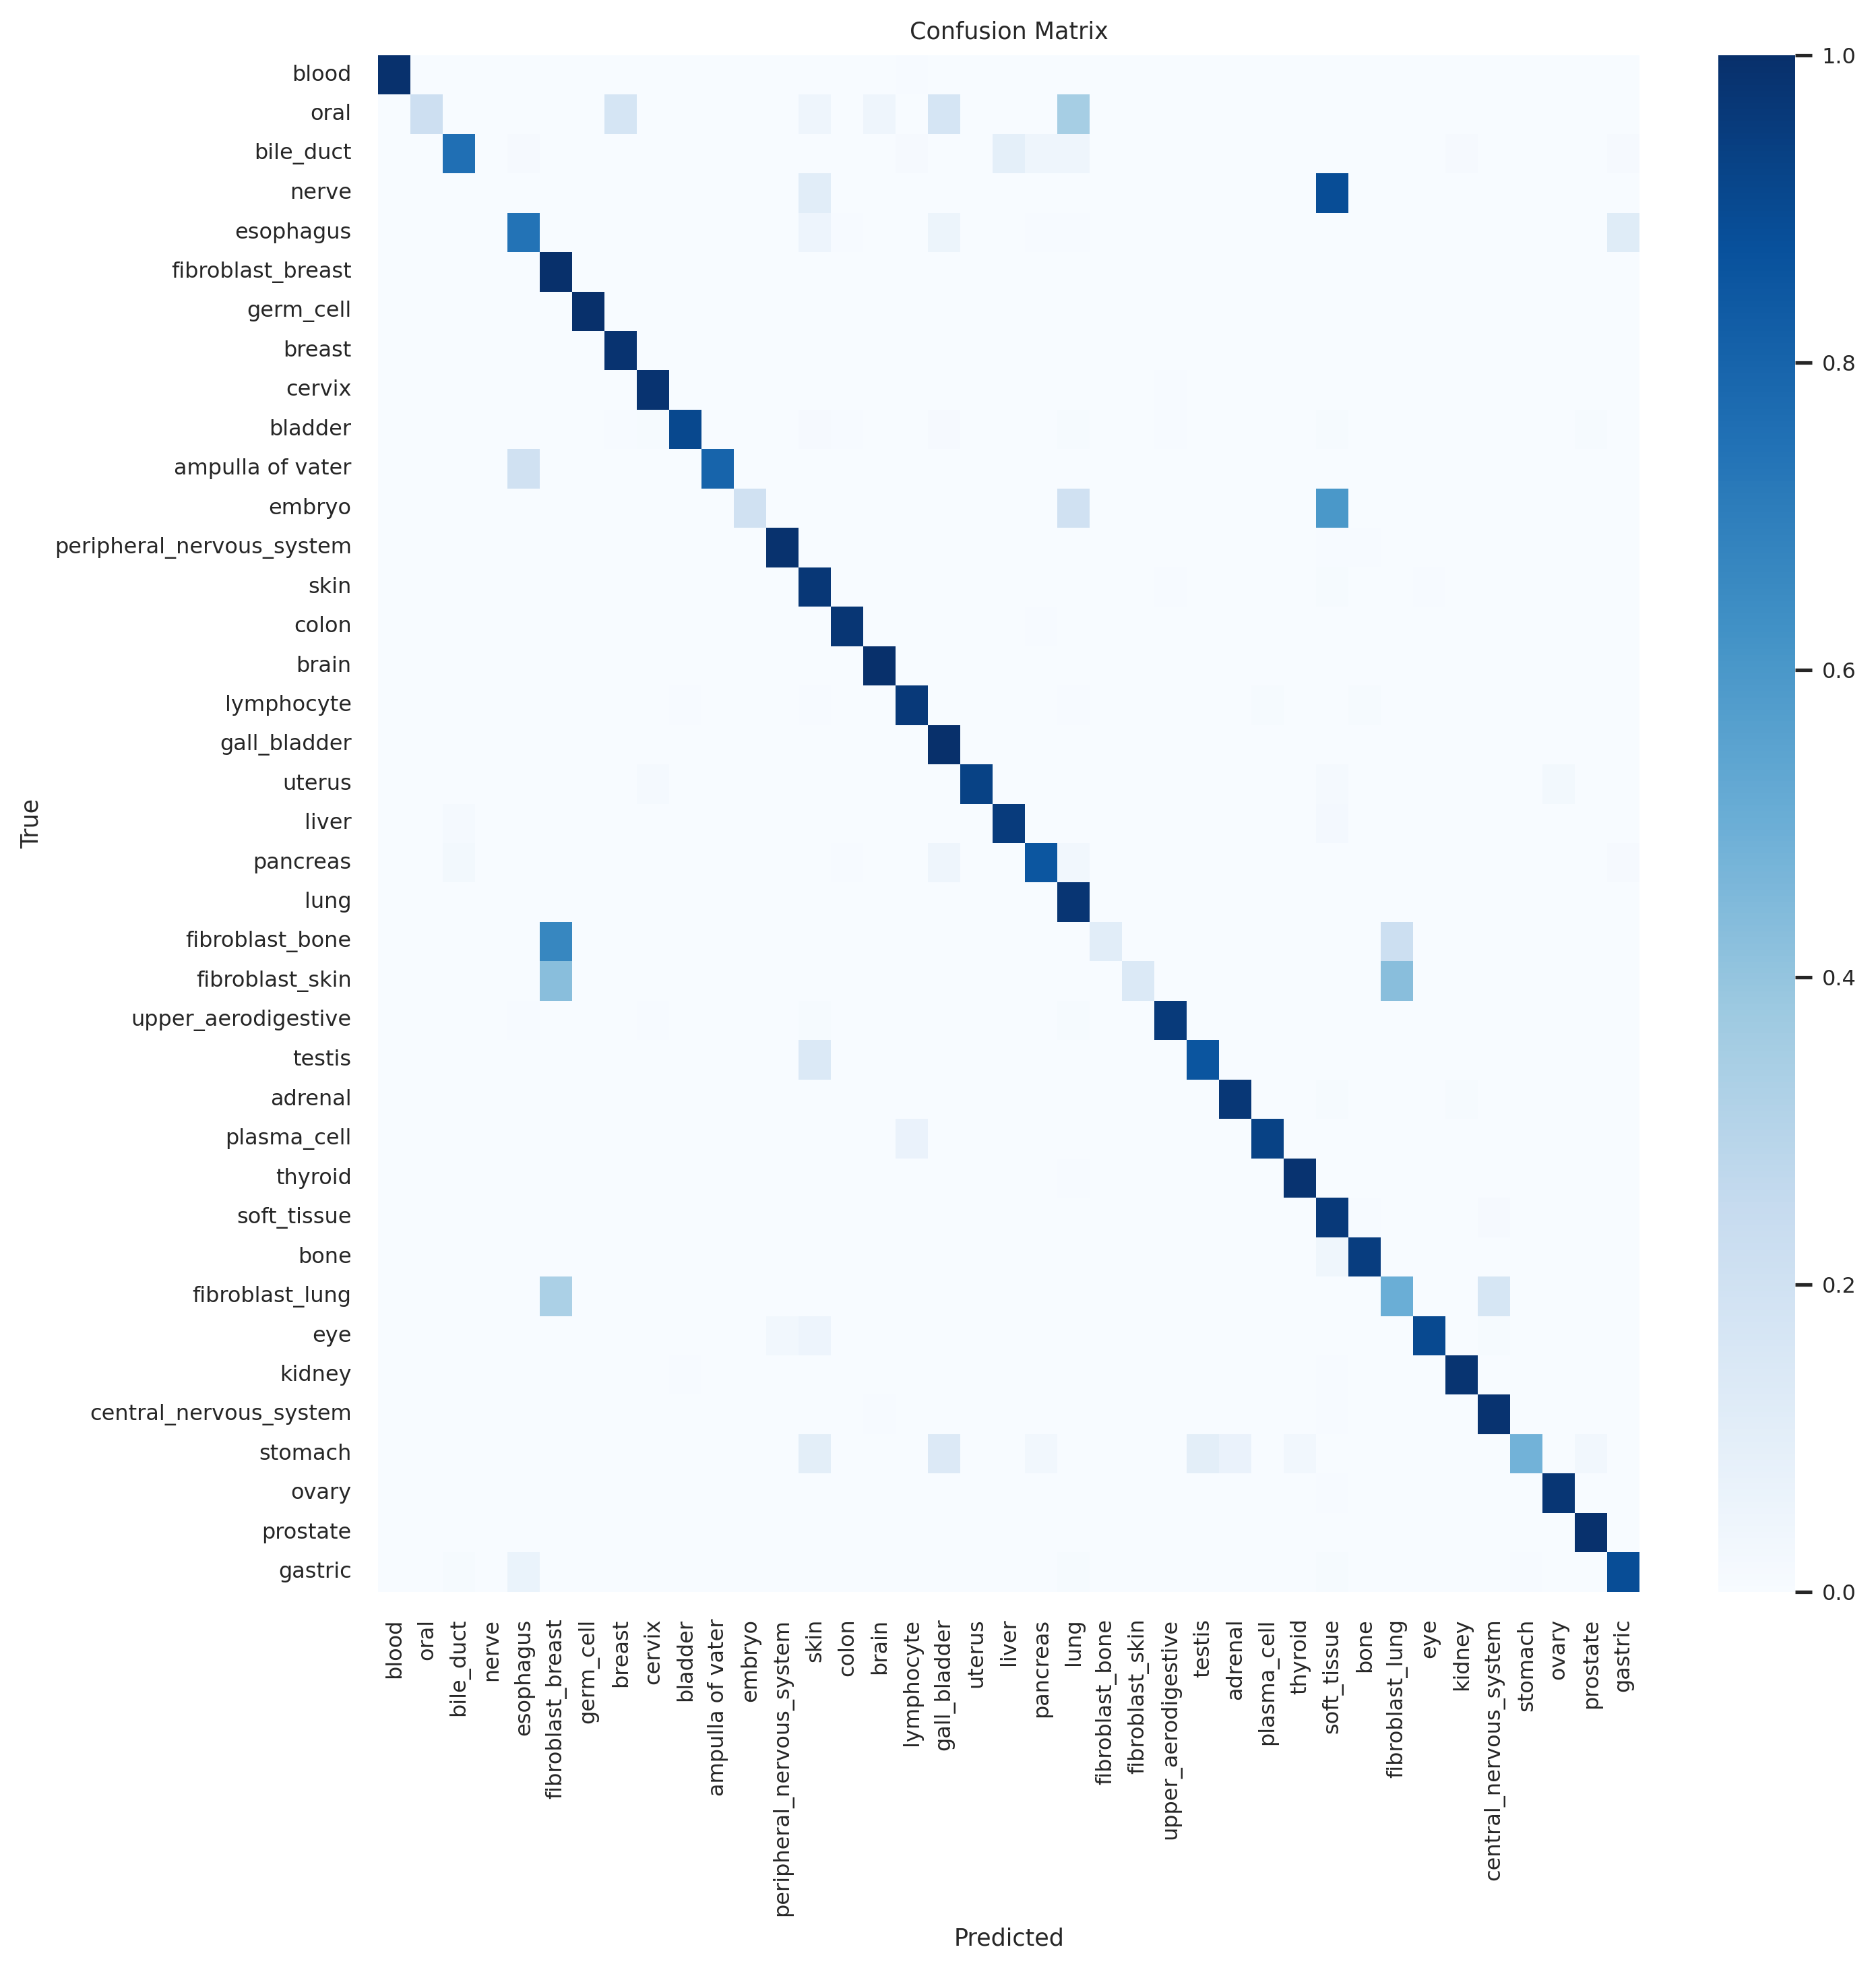

In [133]:
conf = evaluator.getconfusionMatrix(on="lineage", only=None, font_scale=.7)

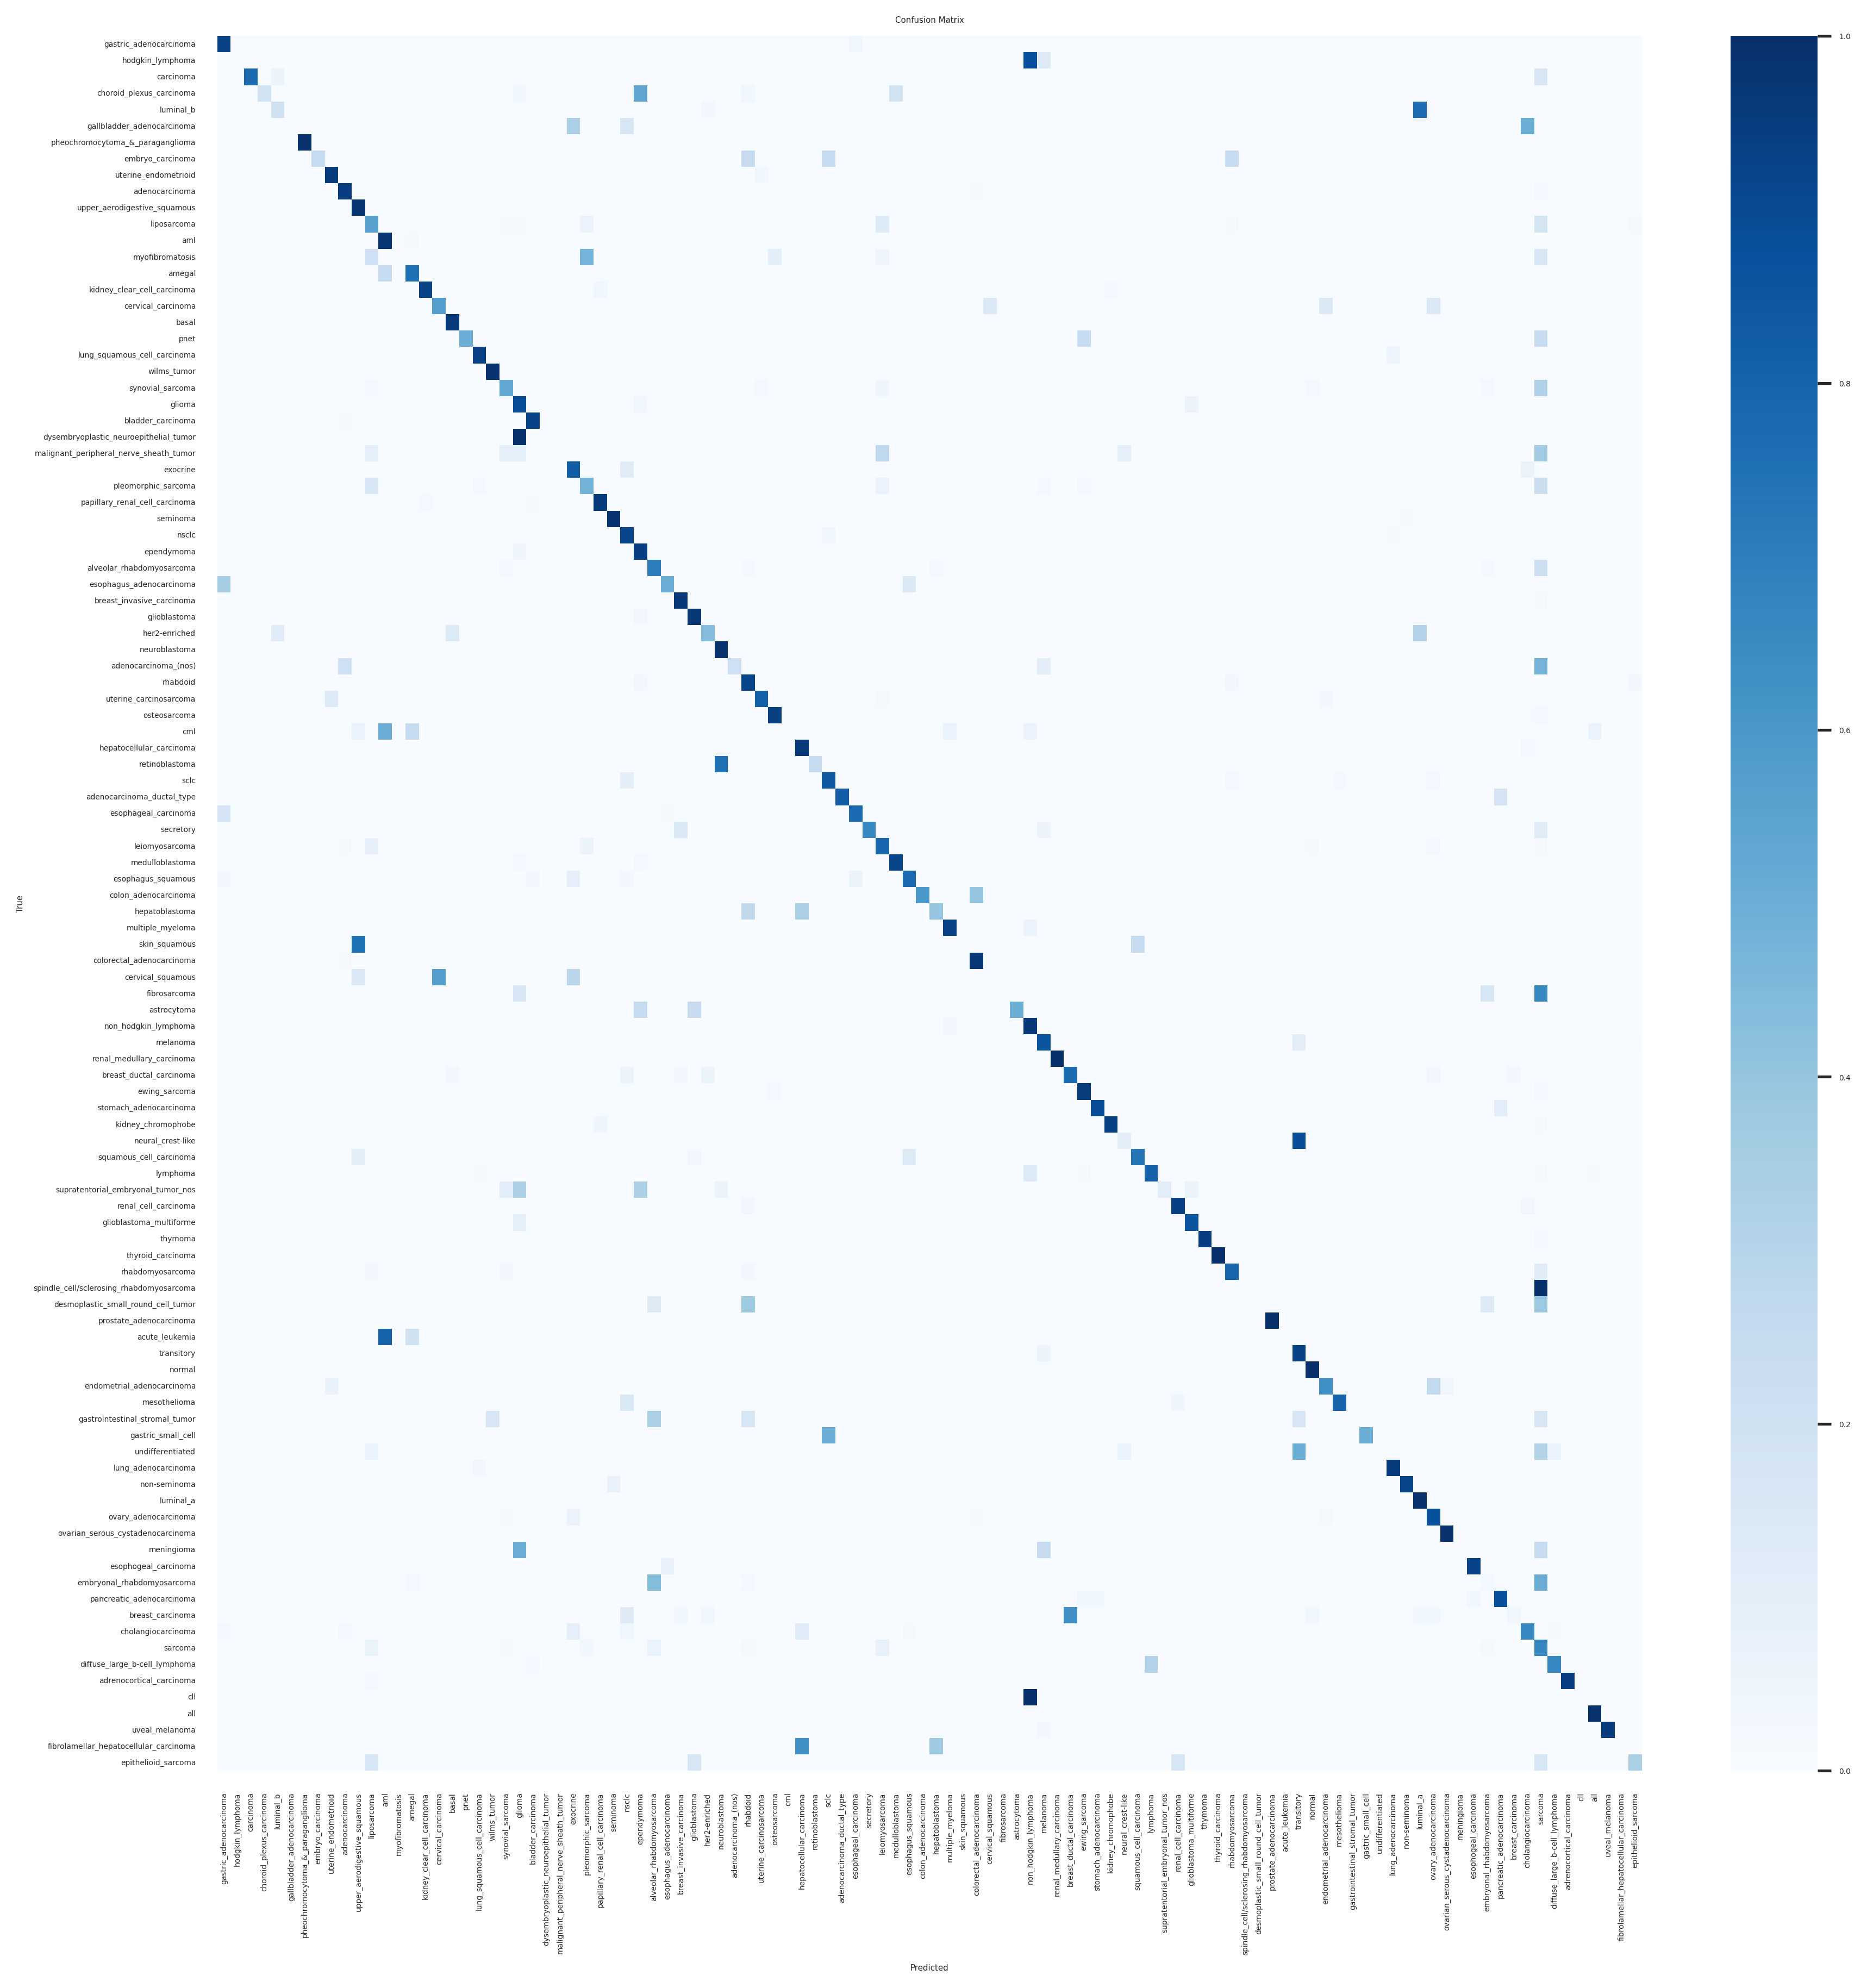

In [134]:
conf = evaluator.getconfusionMatrix(on="disease_type", only=None, figsize=(14,14), font_scale=.3)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'reference' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be r

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'passage_number' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'contamination' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated an

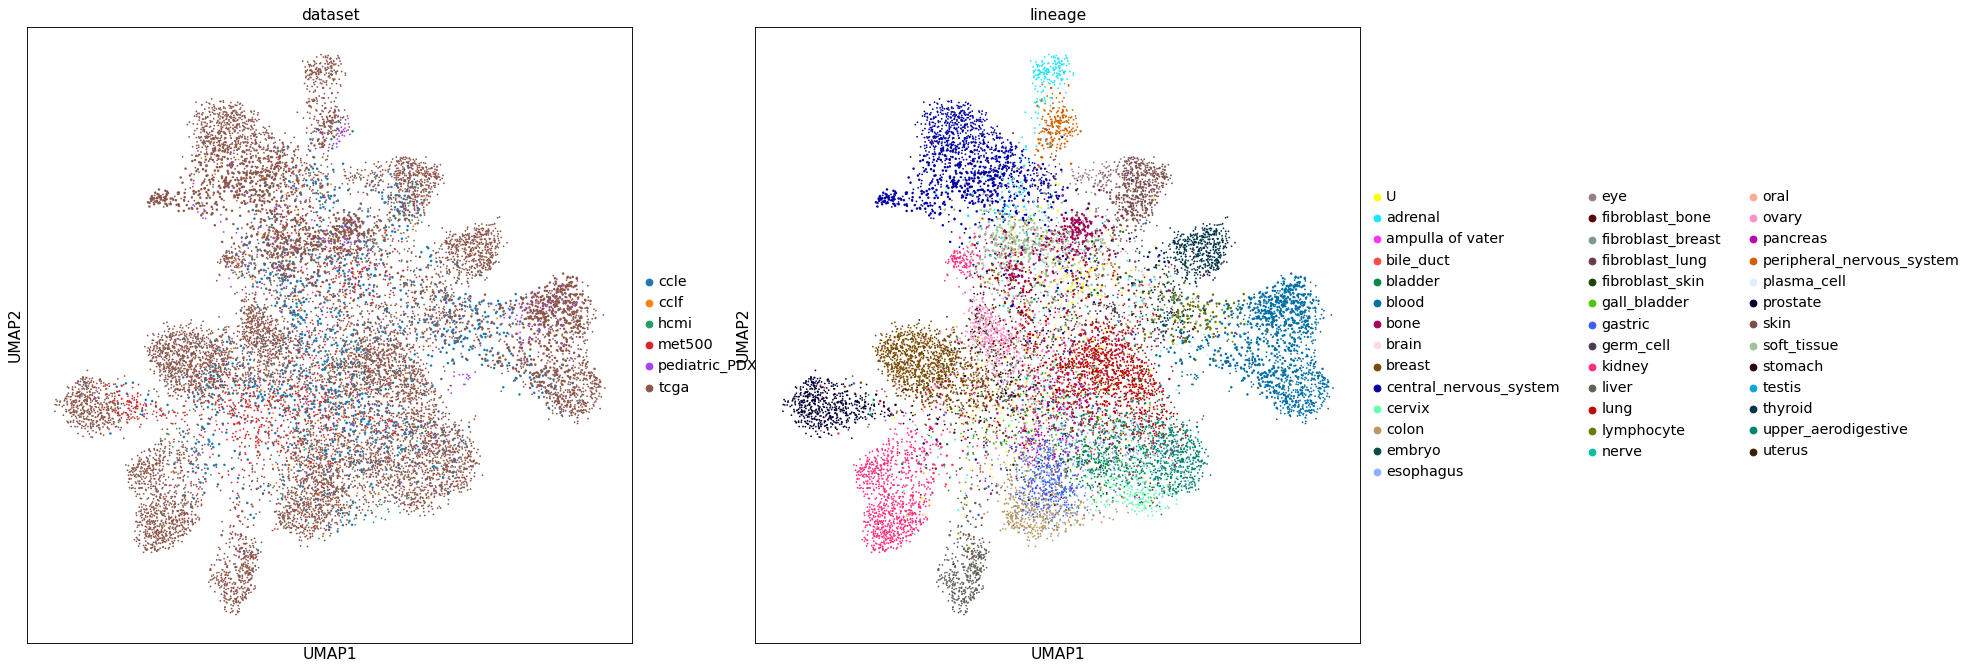

In [40]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [20] * len(dataset[dataset.obs['dataset']!='tcga']) + [10] * len(dataset[dataset.obs['dataset'] == 'tcga']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


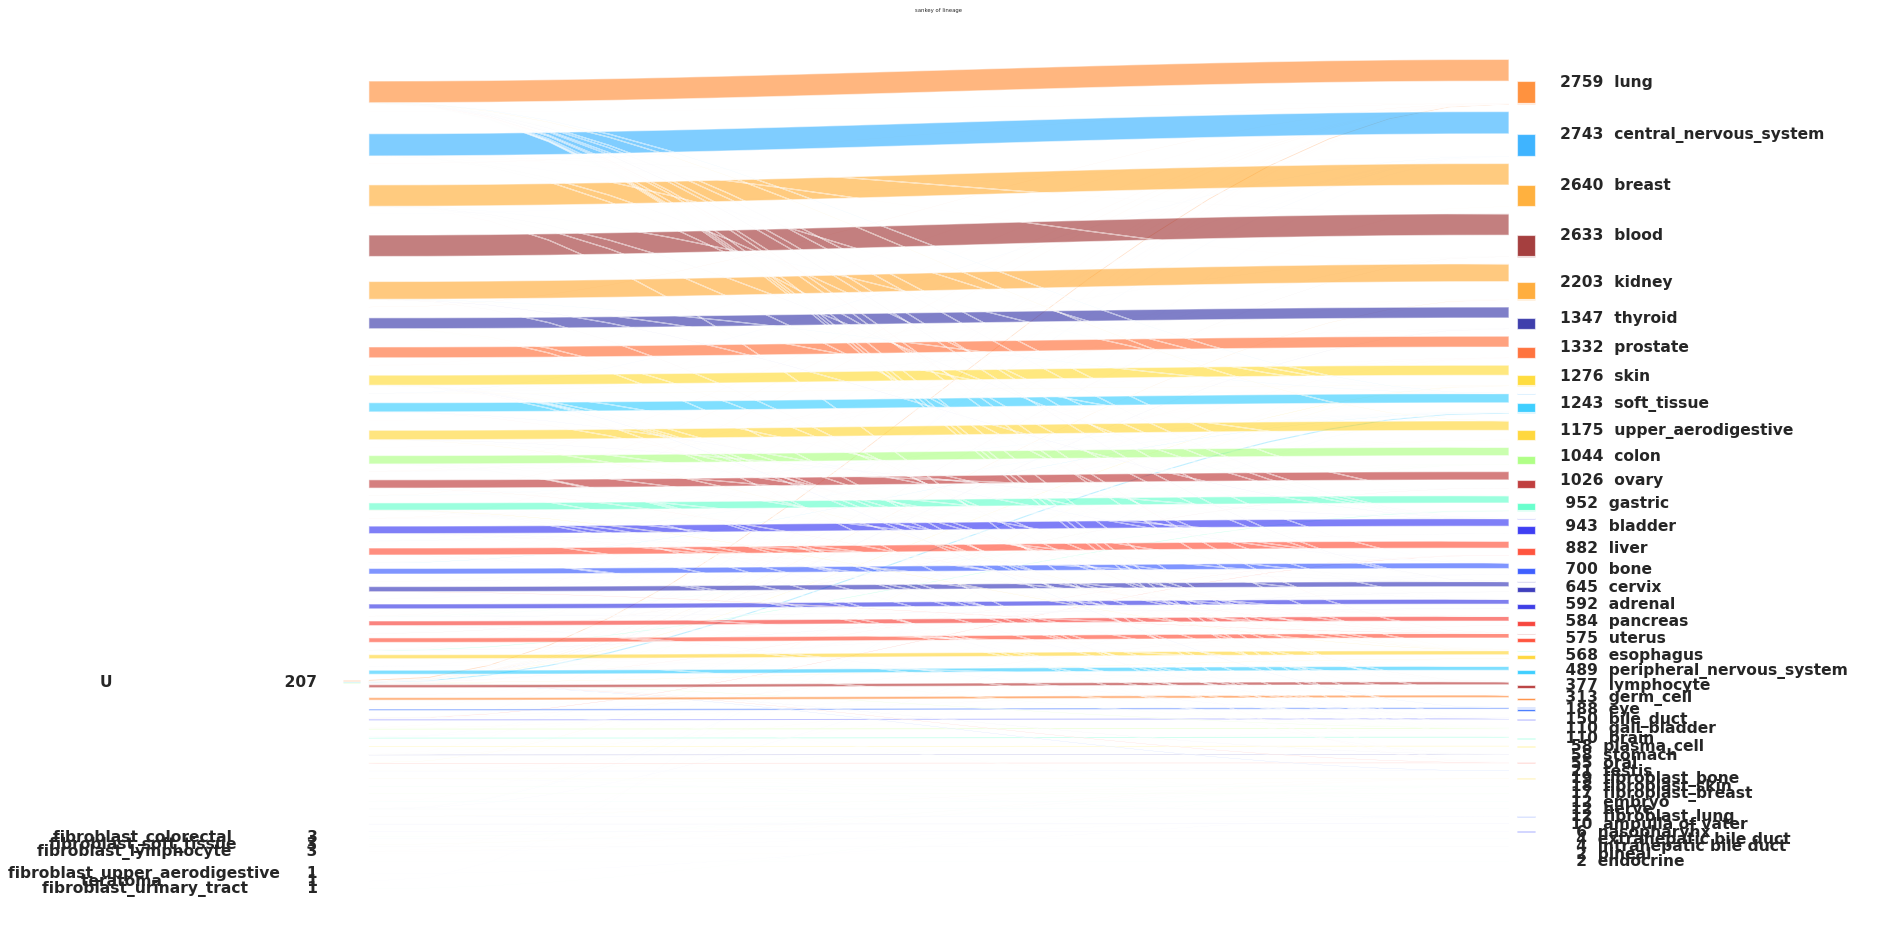

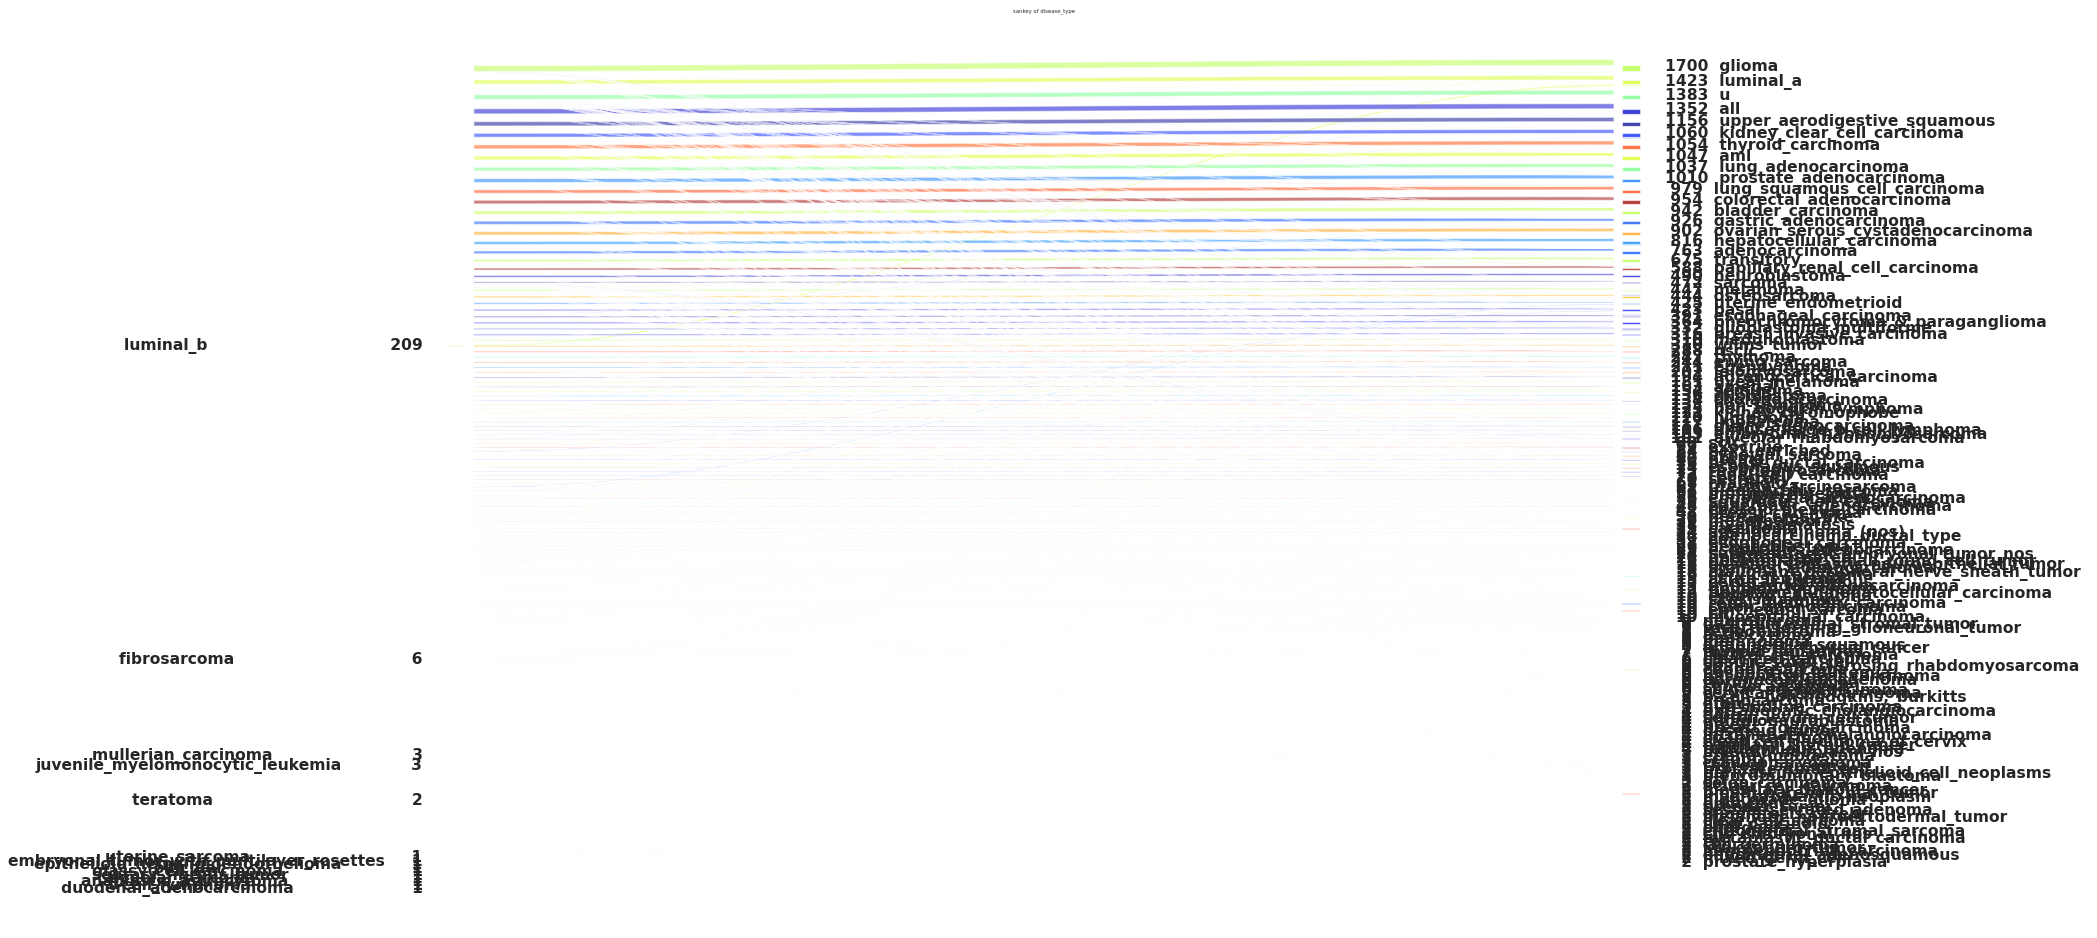

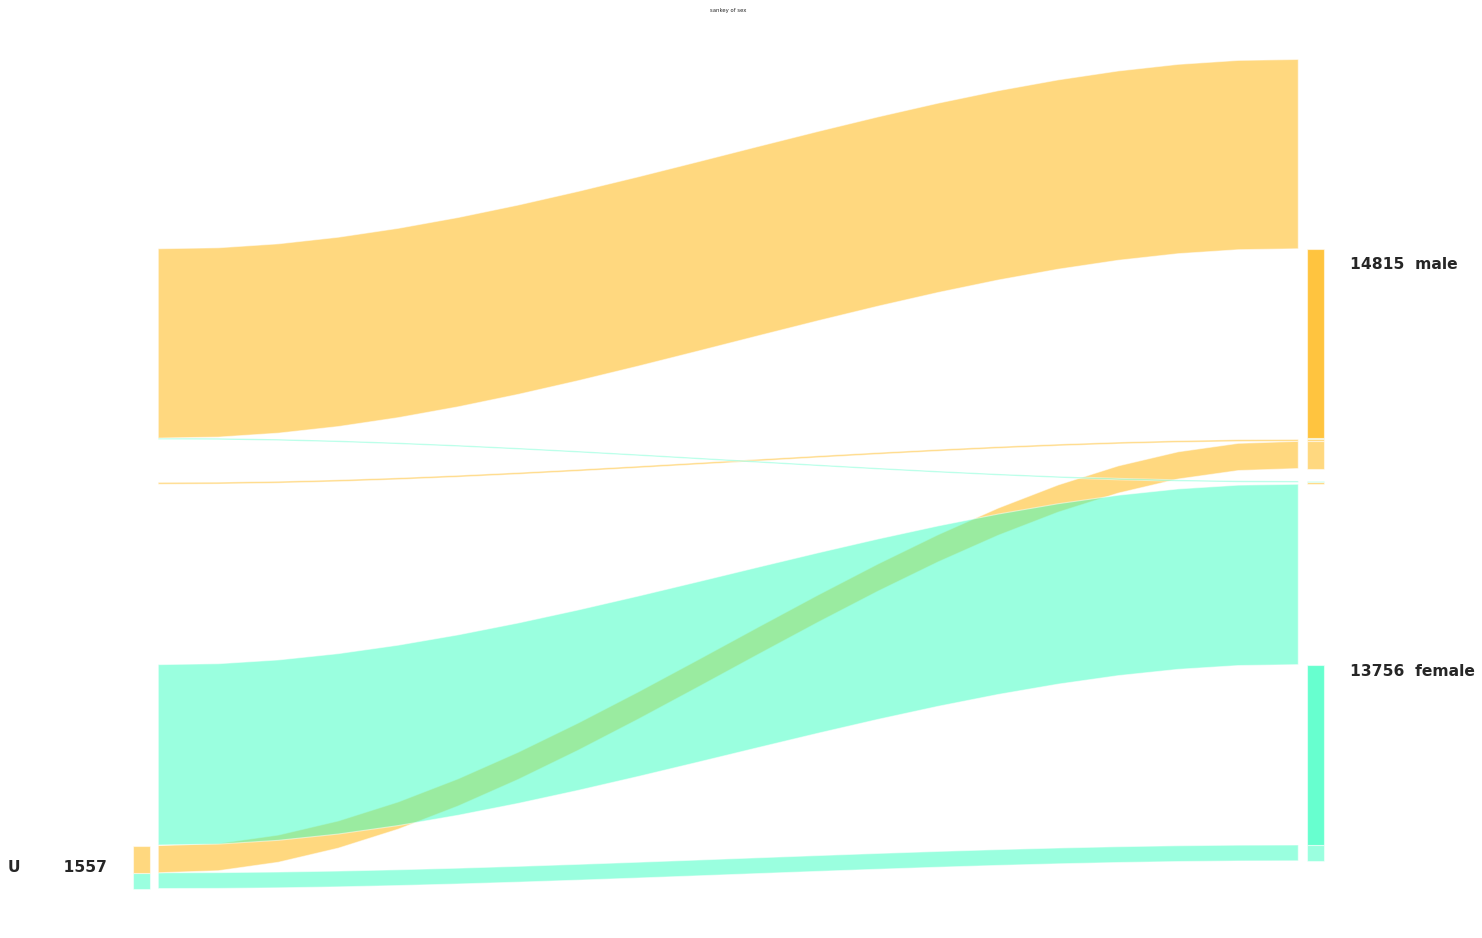

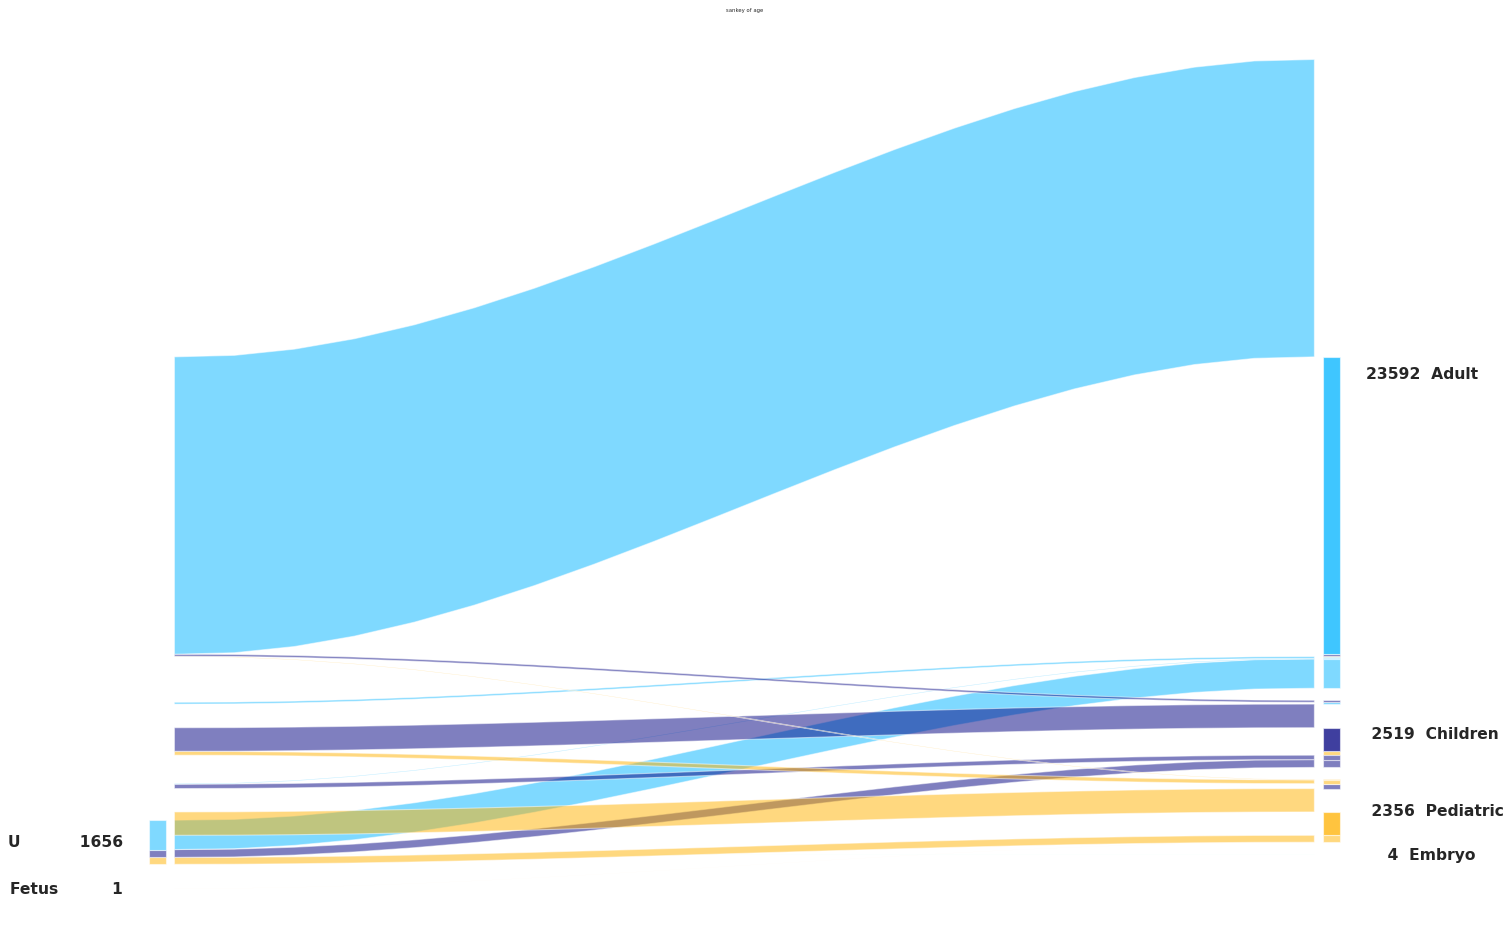

In [218]:
evaluator.plot_classification(classes=['lineage', 'disease_type', 'sex', 'age'])

these are considered to be the same:

'lymphoma', 'lymphocyte'
'lymphoma', 'diffuse_large_b-cell_lymphoma'
'recurrent', 'dysembryoplastic_neuroepithelial_tumor'
'embryo_carcinoma', 'desmoplastic_small_round_cell_tumor'
'breast', 'luminal_a'
'pleomorphic_sarcoma', 'undifferentiated'
'pleomorphic_sarcoma', 'myofibromatosis'
'colorectal_adenocarcinoma', 'colon'
'uterine_endometrioid', 'uterus'
'breast_ductal_carcinoma', 'breast_carcinoma'
'nerve', 'spindle_cell/sclerosing_rhabdomyosarcoma'
'nerve', 'malignant_peripheral_nerve_sheath_tumor'
'her2-enriched', 'luminal_b'
'her2-enriched', 'luminal_a'
'multiple_myeloma', 'plasma_cell'
'upper_aerodigestive', 'upper_aerodigestive_squamous'
'uveal_melanoma', 'eye'
'liver', 'hepatocellular_carcinoma'
'bladder_carcinoma', 'bladder'
'brain', 'glioblastoma'
'spindle_cell/sclerosing_rhabdomyosarcoma', 'embryonal_rhabdomyosarcoma'
'spindle_cell/sclerosing_rhabdomyosarcoma', 'alveolar_rhabdomyosarcoma'
'spindle_cell/sclerosing_rhabdomyosarcoma', 'gastro

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


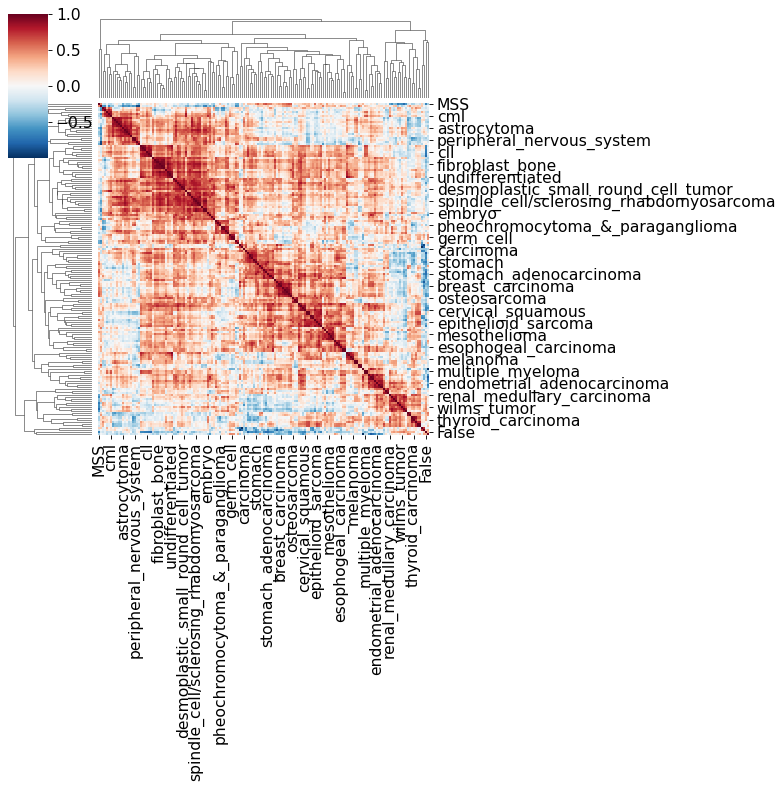

In [235]:
corr, same = evaluator.getClassCorrelation() #fullpred

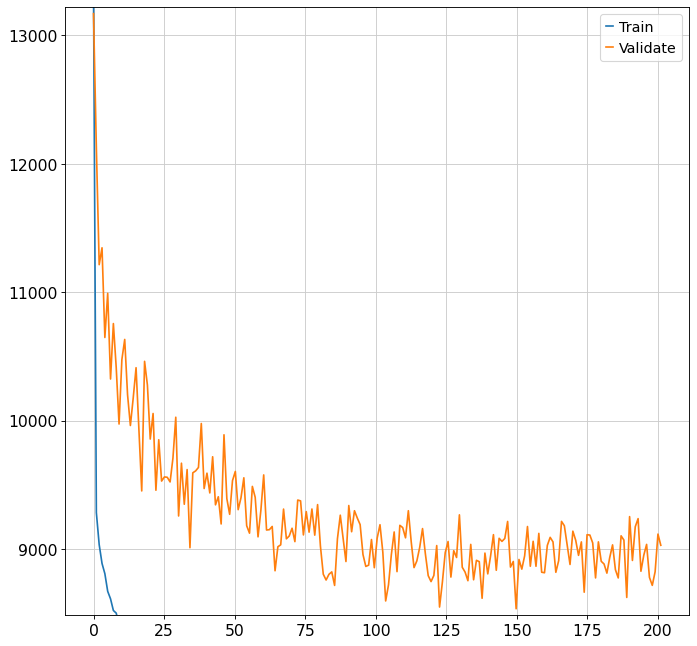

<Figure size 800x800 with 0 Axes>

In [31]:
evaluator.plot_history()

In [67]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.904472541796136
ASW on celltypes: 0.5204207189381123
Calculating EBM with n_cat = 40
Latent-Space Score EBM+KNN, EBM, KNN: 0.64, 0.26, 0.38


ModuleNotFoundError: No module named 'louvain'

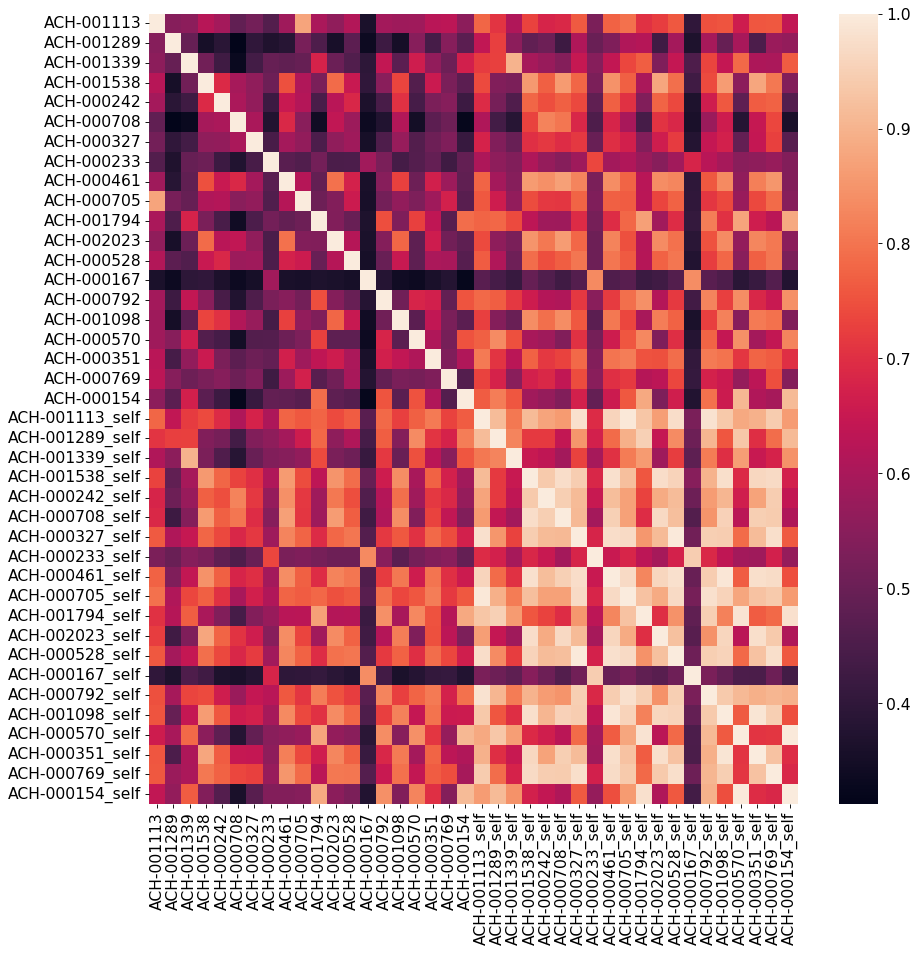

In [111]:
size = 20

corr = evaluator.compare_to(evaluator.reconstruct(samples=cl2.adata.obs.iloc[:size].index))

In [1]:
cl2

NameError: name 'cl2' is not defined

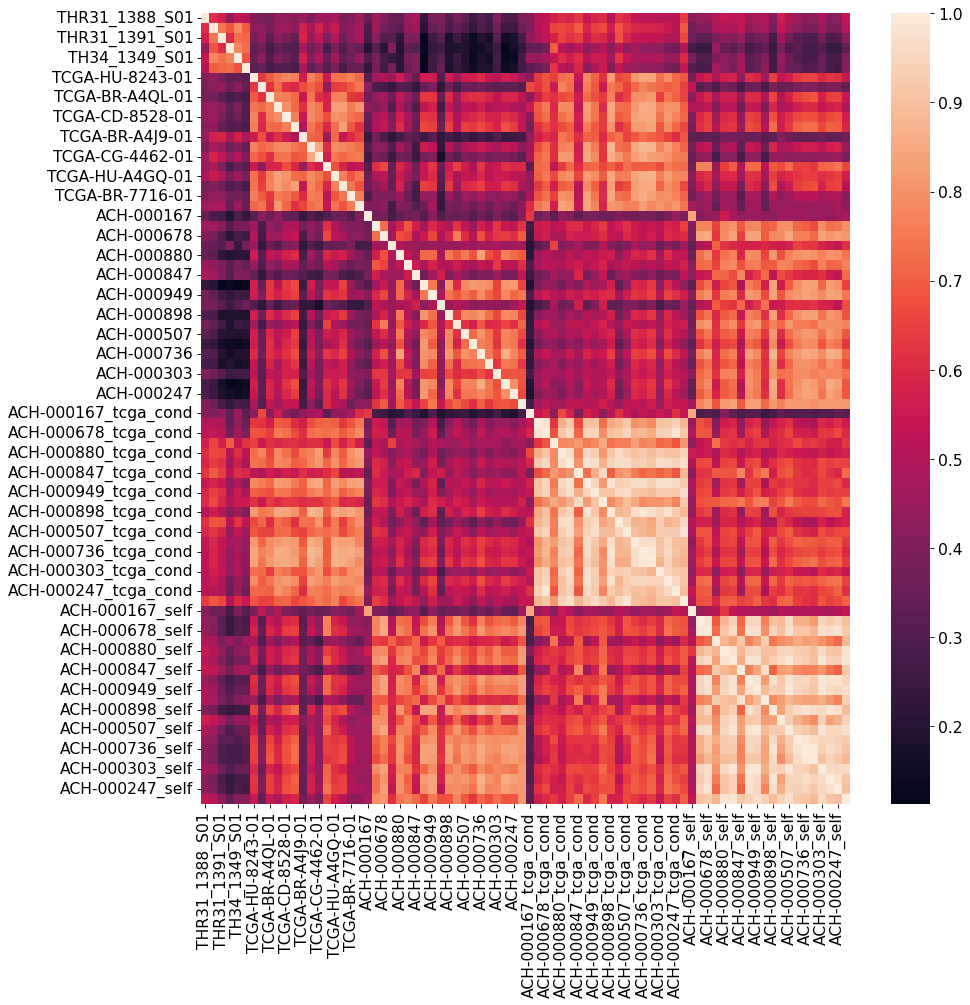

In [112]:
size = 20
sa = cl2.adata.obs
cl = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].iloc[:size]
tm = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].iloc[:size]

reco = evaluator.reconstruct(samples=cl.index, tcga_cond=tm)
corr = evaluator.compare_to(reco, samples=tm.index)

In [117]:
corr.loc[[i+"_tcga_cond" for i in cl.index],cl.index.tolist()].mean().mean()

0.48525195275694405

In [118]:
corr.loc[[i+"_tcga_cond" for i in cl.index],tm.index.tolist()].mean().mean()

0.6554453415977888

In [119]:
corr.loc[[i+"_tcga_cond" for i in cl.index],[i+"_self" for i in cl.index]].mean().mean()

0.5987814333661786

In [173]:
dataset = evaluator.imputeMissing(dataset, classonly=True, only=cols)

### MMD on Y1

In [175]:
cols = ['dataset', 'reference', 'sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format'] #'morphology', 'contamination', 'passage_number']

In [176]:
pred = ['lineage', 'age', "sex", 'disease_type', 'cell_type', 'instability', 'hasebv', 'stage']

In [236]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 27
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 164 

Decoder Architecture:
	First Layer in, out and cond:  16 128 27
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |██------------------| 11.3%  - val_loss: 8218.4444661458 - val_recon_loss: 4723.5569661458 - val_kl_loss: 171.6069997152 - val_class_ce_loss: 306.7631329377 - val_mmd_loss: 3188.0960327148
ADJUSTED LR
 |██------------------| 13.7%  - val_loss: 8120.6605631510 - val_recon_loss: 4698.9834635417 - val_kl_loss: 171.2610178630 - val_class_ce_loss: 233.3952557246 - val_mmd_loss: 3188.2475163778
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 19


In [237]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [238]:
evaluator.get_class_quality(classes=pred)

lineage
all predicted categories:  {'gastric', 'kidney', 'lymphocyte', 'pancreas', 'plasma_cell', 'breast', 'uterus', 'gall_bladder', 'prostate', 'cervix', 'skin', 'soft_tissue', 'blood', 'thyroid', 'peripheral_nervous_system', 'esophagus', 'oral', 'adrenal', 'bladder', 'bone', 'central_nervous_system', 'eye', 'upper_aerodigestive', 'bile_duct', 'ovary', 'ampulla of vater', 'liver', 'germ_cell', 'lung', 'testis', 'colon', 'brain', 'stomach'}
accuracy:  0.932989340756331
F1 Score (weigthed): 0.94
F1 Score (macro): 0.70


age
all predicted categories:  {'Adult', 'Pediatric', 'Children'}
accuracy:  0.9396422128683103
F1 Score (weigthed): 0.94
F1 Score (macro): 0.59


sex
all predicted categories:  {'female', 'male'}
accuracy:  0.9896907216494846
F1 Score (weigthed): 0.99
F1 Score (macro): 0.99


disease_type
all predicted categories:  {'aml', 'lymphoma', 'stomach_adenocarcinoma', 'liposarcoma', 'esophogeal_carcinoma', 'colorectal_adenocarcinoma', 'esophageal_carcinoma', 'pnet', 'adenocarc

In [240]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.7128914915865308
ASW on celltypes: 0.5853704661130905
Calculating EBM with n_cat = 40
Latent-Space Score EBM+KNN, EBM, KNN: 0.77, 0.08, 0.69


ModuleNotFoundError: No module named 'louvain'

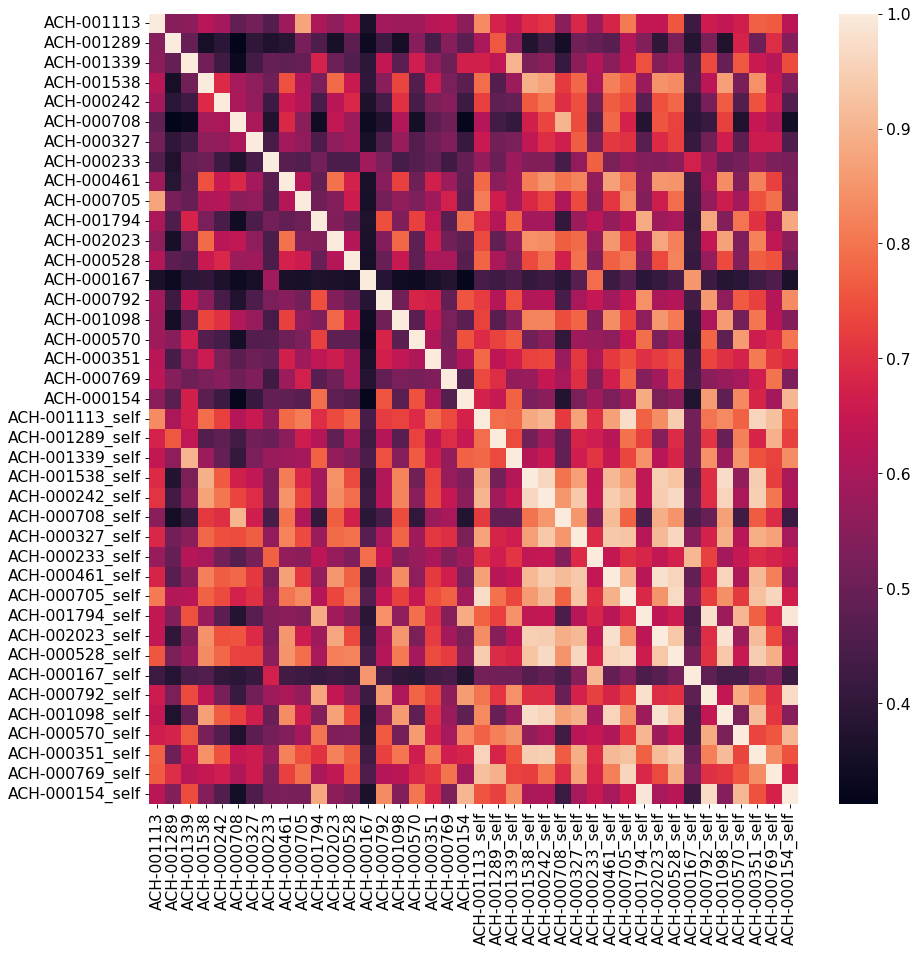

In [241]:
size = 20

corr = evaluator.compare_to(evaluator.reconstruct(samples=cl2.adata.obs.iloc[:size].index))

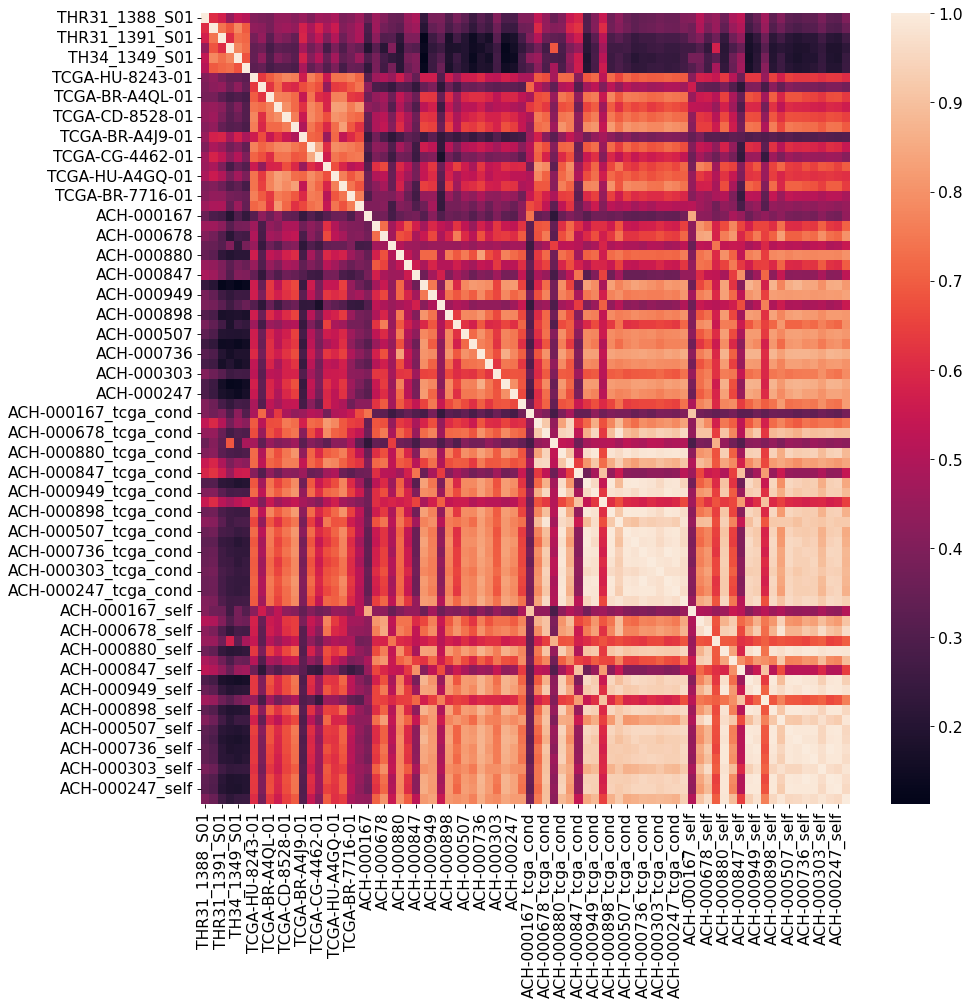

In [242]:
size = 20
sa = cl2.adata.obs
cl = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].iloc[:size]
tm = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].iloc[:size]

reco = evaluator.reconstruct(samples=cl.index, tcga_cond=tm)
corr = evaluator.compare_to(reco, samples=tm.index)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'reference' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be r

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'instability_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hasebv_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated an

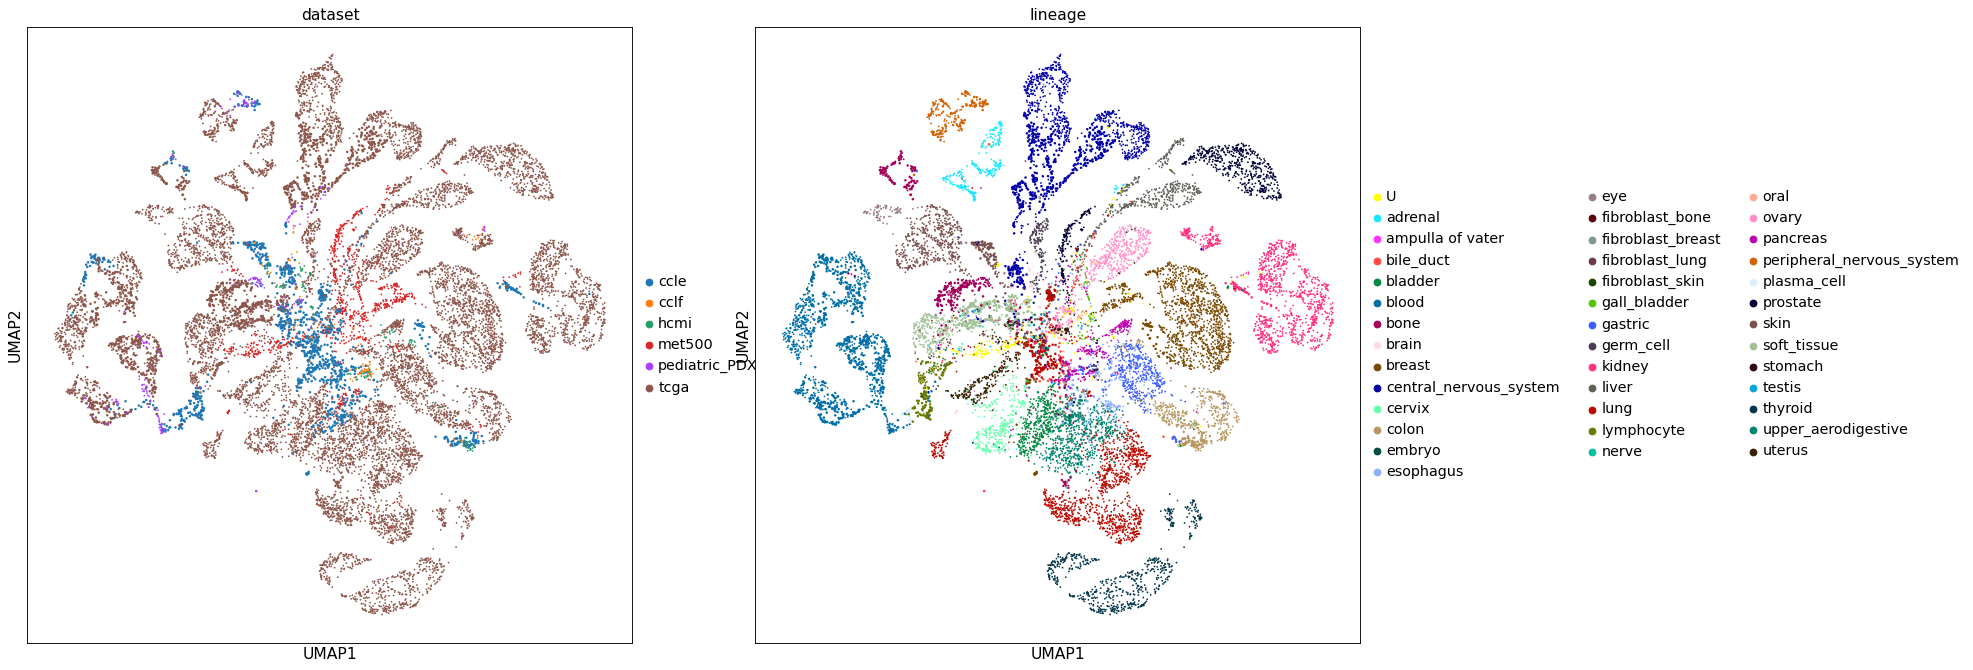

In [239]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [20] * len(dataset[dataset.obs['dataset']!='tcga']) + [10] * len(dataset[dataset.obs['dataset'] == 'tcga']))

### large input / output module (50x  initial model size)

In [243]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[1024, 256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=24,
    beta=500,
    betaclass=0.8,
    mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 1024 27
	Hidden Layer 1 in/out: 1024 256
	Hidden Layer 2 in/out: 256 128
	Mean/Var Layer in/out: 128 24
Classifier Architecture:
	First Layer in/out:  24 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 164 

Decoder Architecture:
	First Layer in, out and cond:  24 128 27
	Hidden Layer 1 in/out: 128 256
	Hidden Layer 2 in/out: 256 1024
	Output Layer in/out:  1024 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |████----------------| 24.3%  - val_loss: 7697.8735026042 - val_recon_loss: 4592.1404296875 - val_kl_loss: 251.6208414714 - val_class_ce_loss: 224.1097037117 - val_mmd_loss: 2881.53272857674
ADJUSTED LR
 |█████---------------| 29.3%  - val_loss: 7708.4061360677 - val_recon_loss: 4539.2940429687 - val_kl_loss: 255.1247522990 - val_class_ce_loss: 183.9480918129 - val_mmd_loss: 2985.0530502319
ADJUSTED LR
 |██████--------------| 31.7%  - val_loss: 7206.8036458333 - val_recon_loss: 4530.1786132813 - val_kl_loss: 251.8527175903 - val_class_ce_loss: 183.3795694351 - val_mmd_loss: 2493.1271021525
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 73


In [244]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [245]:
evaluator.get_class_quality(classes=pred)

lineage
all predicted categories:  {'gastric', 'kidney', 'lymphocyte', 'pancreas', 'plasma_cell', 'fibroblast_bone', 'breast', 'uterus', 'fibroblast_breast', 'fibroblast_skin', 'gall_bladder', 'prostate', 'skin', 'cervix', 'embryo', 'soft_tissue', 'blood', 'thyroid', 'peripheral_nervous_system', 'esophagus', 'oral', 'adrenal', 'bone', 'bladder', 'central_nervous_system', 'eye', 'upper_aerodigestive', 'bile_duct', 'ovary', 'ampulla of vater', 'liver', 'germ_cell', 'lung', 'testis', 'colon', 'brain', 'stomach'}
accuracy:  0.9760336750628013
F1 Score (weigthed): 0.98
F1 Score (macro): 0.86


age
all predicted categories:  {'Adult', 'Pediatric', 'Children'}
accuracy:  0.959786530366807
F1 Score (weigthed): 0.96
F1 Score (macro): 0.64


sex
all predicted categories:  {'female', 'male'}
accuracy:  0.9923800986104886
F1 Score (weigthed): 0.99
F1 Score (macro): 0.99


disease_type
all predicted categories:  {'aml', 'lymphoma', 'embryo_carcinoma', 'stomach_adenocarcinoma', 'liposarcoma', 'esoph

In [246]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.7496476898012585
ASW on celltypes: 0.608805425465107
Calculating EBM with n_cat = 40
Latent-Space Score EBM+KNN, EBM, KNN: 0.80, 0.05, 0.75


ModuleNotFoundError: No module named 'louvain'

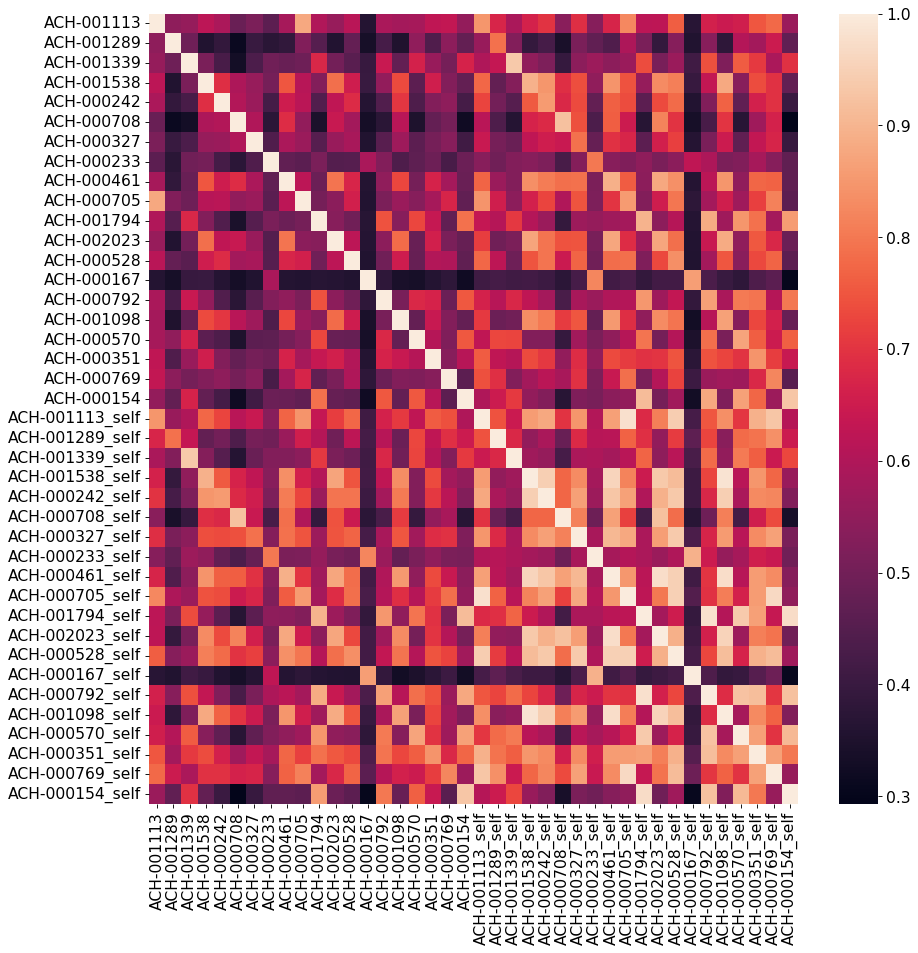

In [247]:
size = 20

corr = evaluator.compare_to(evaluator.reconstruct(samples=cl2.adata.obs.iloc[:size].index))

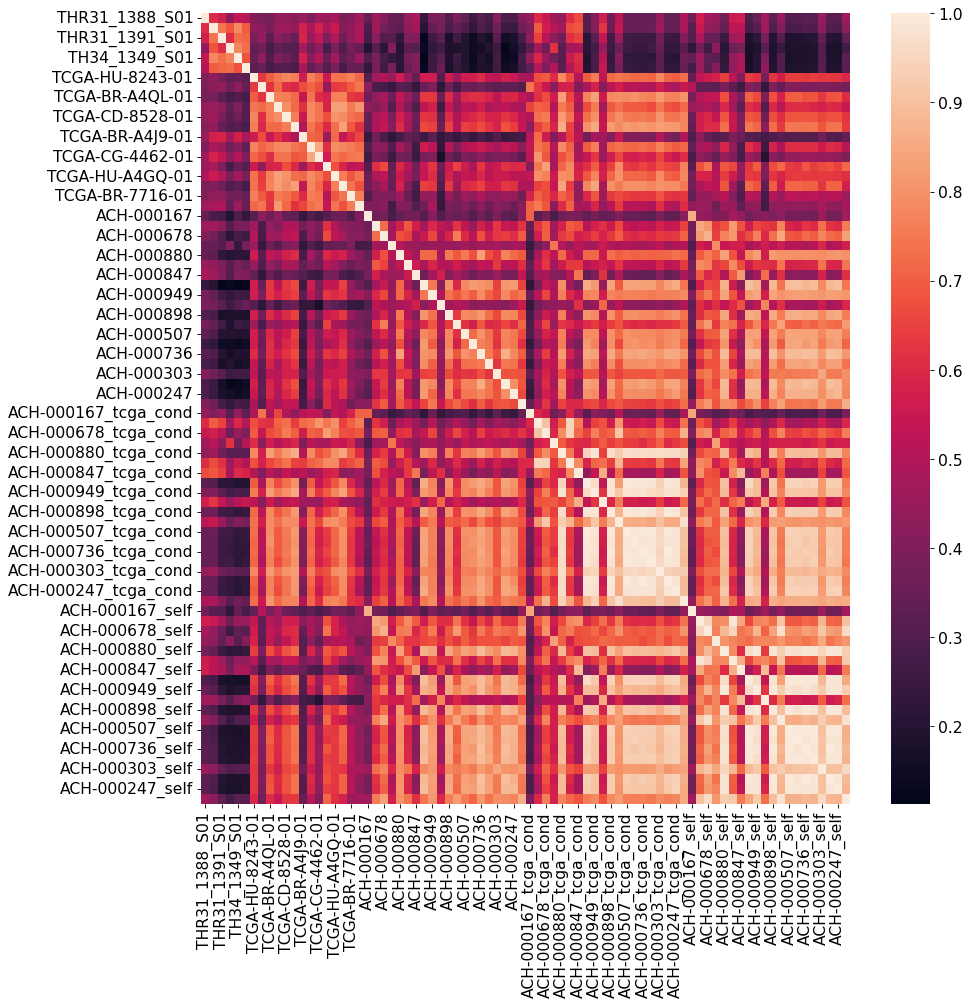

In [248]:
size = 20
sa = cl2.adata.obs
cl = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].iloc[:size]
tm = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].iloc[:size]

reco = evaluator.reconstruct(samples=cl.index, tcga_cond=tm)
corr = evaluator.compare_to(reco, samples=tm.index)

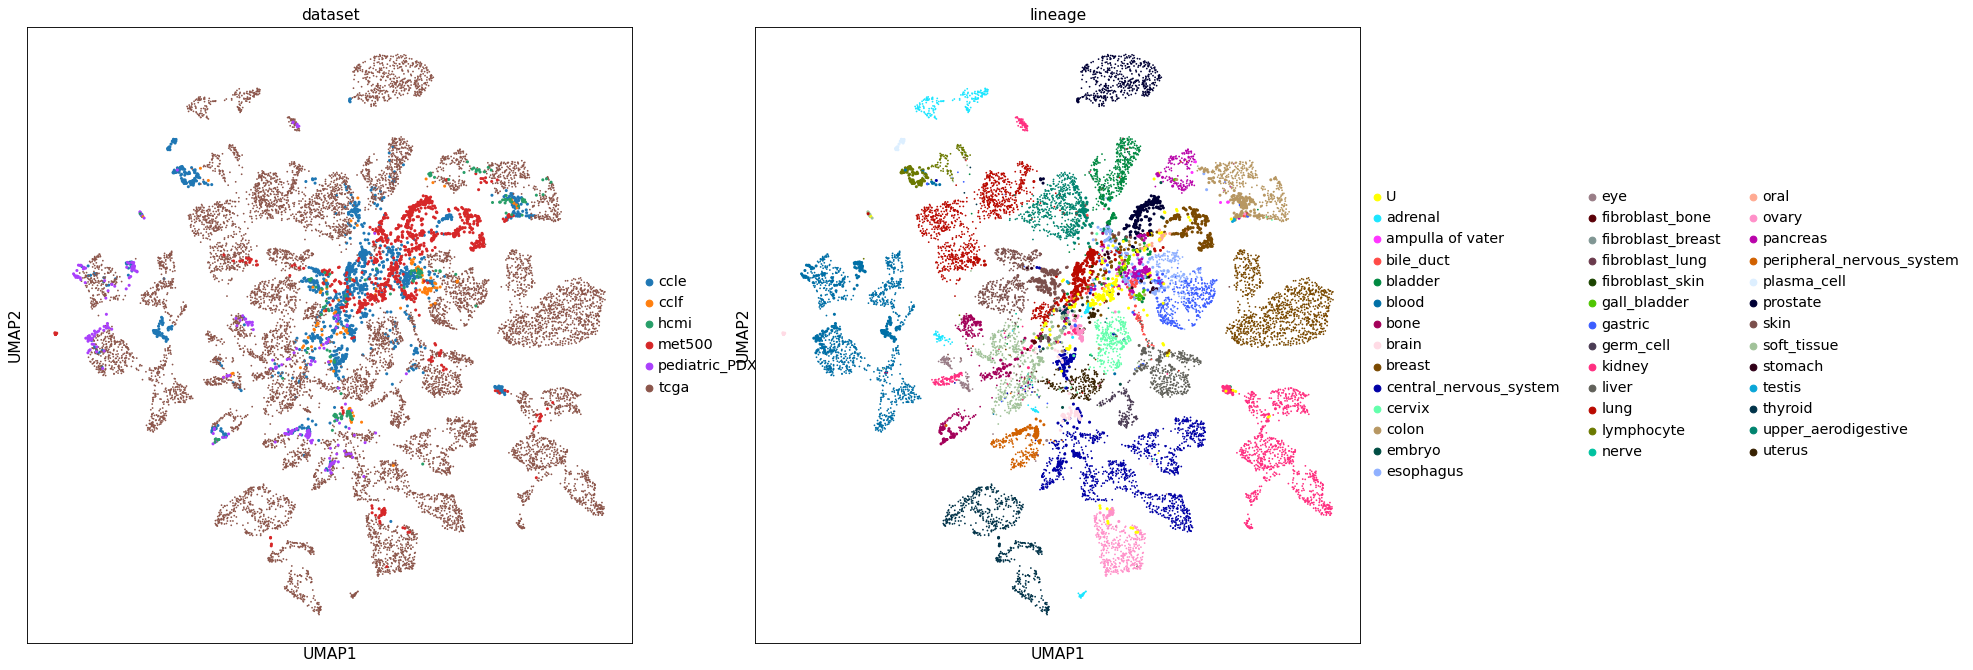

In [251]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val !='tcga' else 10 for val in dataset.obs['dataset']])

### small set of pred/cond values

In [282]:
cols = ['dataset']

In [283]:
pred = ['lineage',
 'age',
 'sex',
 'disease_type']

In [284]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 6
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 151 

Decoder Architecture:
	First Layer in, out and cond:  16 128 6
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |███-----------------| 18.3%  - val_loss: 22689.7676106771 - val_recon_loss: 5225.9599121094 - val_kl_loss: 65.6968452454 - val_class_ce_loss: 771.5612195333 - val_mmd_loss: 16692.22892252601
ADJUSTED LR
 |████----------------| 20.7%  - val_loss: 20357.1873535156 - val_recon_loss: 5191.1973958333 - val_kl_loss: 65.6943763733 - val_class_ce_loss: 647.3413636525 - val_mmd_loss: 14518.6283528646
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 40


In [285]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [286]:
evaluator.get_class_quality(classes=pred)

lineage
all predicted categories:  {'kidney', 'lymphocyte', 'pancreas', 'breast', 'gall_bladder', 'prostate', 'cervix', 'skin', 'soft_tissue', 'blood', 'thyroid', 'peripheral_nervous_system', 'esophagus', 'adrenal', 'bone', 'central_nervous_system', 'upper_aerodigestive', 'ovary', 'liver', 'germ_cell', 'lung', 'colon', 'brain'}
accuracy:  0.5923009029805146
F1 Score (weigthed): 0.65
F1 Score (macro): 0.28


age
all predicted categories:  {'Adult', 'Pediatric', 'Children'}
accuracy:  0.8886800962116657
F1 Score (weigthed): 0.90
F1 Score (macro): 0.45


sex
all predicted categories:  {'female', 'male'}
accuracy:  0.7092484685492305
F1 Score (weigthed): 0.72
F1 Score (macro): 0.70


disease_type
all predicted categories:  {'adenocarcinoma', 'aml', 'lung_squamous_cell_carcinoma', 'lymphoma', 'nsclc', 'kidney_clear_cell_carcinoma', 'melanoma', 'rhabdomyosarcoma', 'non_hodgkin_lymphoma', 'pheochromocytoma_&_paraganglioma', 'colorectal_adenocarcinoma', 'medulloblastoma', 'secretory', 'prostat

In [258]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...


KeyError: 'cell_type'

In [ ]:
size = 20

corr = evaluator.compare_to(evaluator.reconstruct(samples=cl2.adata.obs.iloc[:size].index))

In [ ]:
size = 20
sa = cl2.adata.obs
cl = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].iloc[:size]
tm = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].iloc[:size]

reco = evaluator.reconstruct(samples=cl.index, tcga_cond=tm)
corr = evaluator.compare_to(reco, samples=tm.index)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be rem

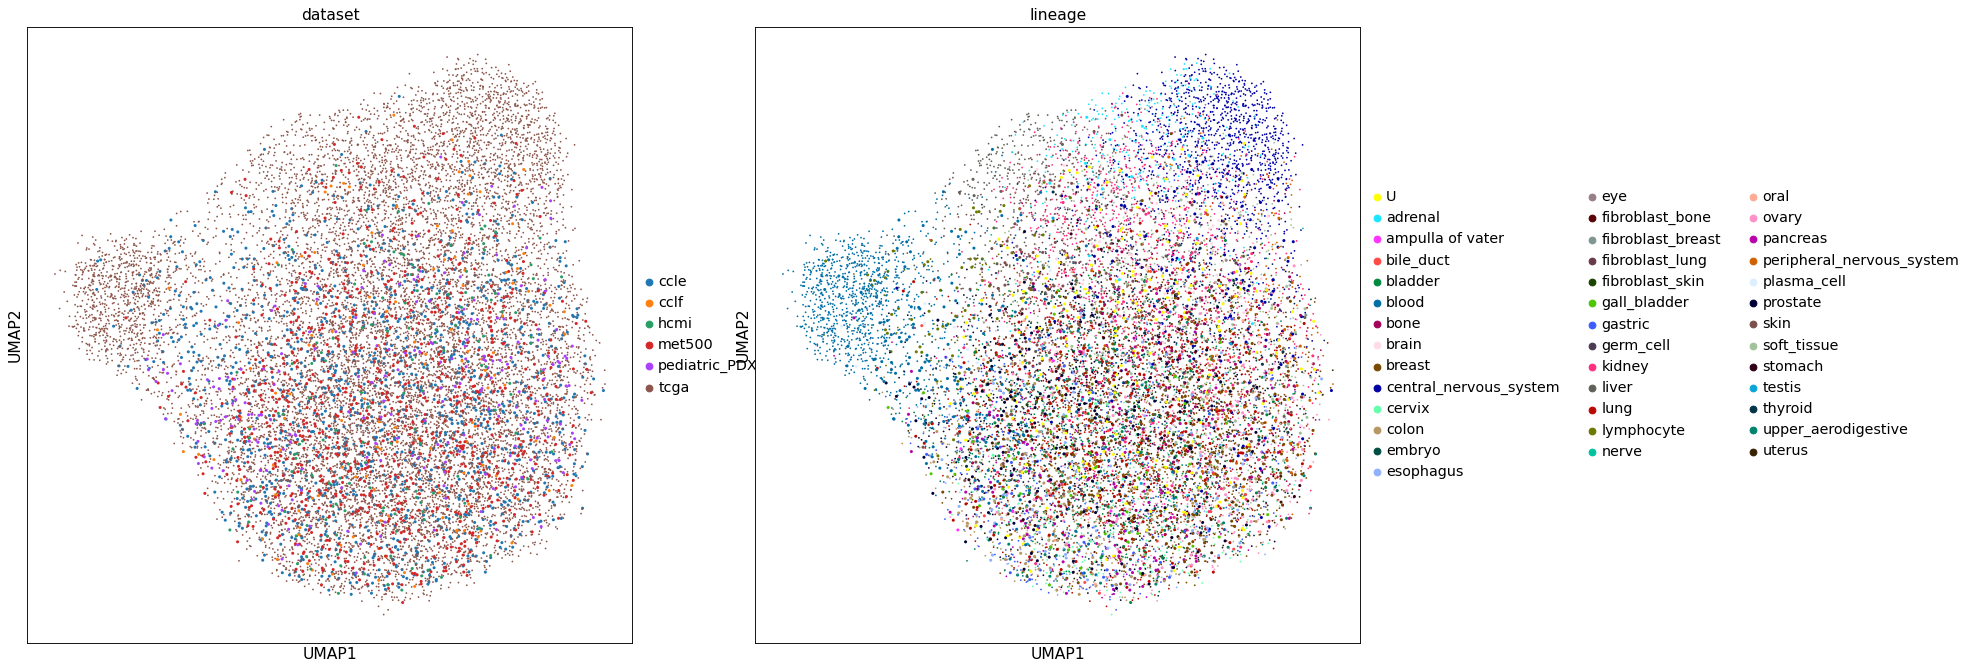

In [287]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val !='tcga' else 10 for val in dataset.obs['dataset']])

### reproducing previous results?? what is going on

In [320]:
olddataset = read_h5ad("temp/celligner_multi.h5ad.gz")

In [345]:
loc = np.argsort(olddataset.X.var(0))[-3000:]
olddataset = AnnData(olddataset.X[:,loc], olddataset.obs, olddataset.var.iloc[loc])

In [321]:
subdataset = dataset[dataset.obs.dataset.isin(['ccle', "tcga"])].copy()

In [346]:
olddataset.X.var(0)

array([ 2.29,  2.29,  2.29,  2.3 ,  2.3 ,  2.3 ,  2.3 , ..., 15.45, 16.37,
       16.6 , 17.12, 18.61, 19.71, 19.75], dtype=float32)

In [342]:
subdataset.X.var(0)

array([ 2.29,  2.29,  2.29,  2.29,  2.29,  2.29,  2.29, ..., 15.48, 16.42,
       16.62, 17.04, 18.64, 19.6 , 19.67], dtype=float32)

In [347]:
oldres = set(olddataset.var.index)
res = set(subdataset.var.index)
len(res & oldres)

2990

In [339]:
#maybe without nans at all?
low_nan_genes = np.isnan(subdataset.X).sum(0)<len(subdataset.X)*0.0001
loc = np.argsort(np.nanvar(subdataset.X[:,low_nan_genes], 0))[-3000:]
subdataset = AnnData(subdataset.X[:,low_nan_genes][:,loc], subdataset.obs, subdataset.var[low_nan_genes].iloc[loc])

### use log transform?

### no classification on cell lines

In [349]:
olddataset.obs

disease_type          cell_type        age     sex  \
ACH-001113            Lung Cancer  historical_CL; 2D      Adult    Male   
ACH-001289               Rhabdoid  historical_CL; 2D  Pediatric    Male   
ACH-001339            Skin Cancer  historical_CL; 2D   Children    Male   
ACH-001538       Bile Duct Cancer  historical_CL; 2D      Adult    Male   
ACH-000242         Bladder Cancer  historical_CL; 2D      Adult    Male   
...                           ...                ...        ...     ...   
TCGA-95-7947-01       Lung Cancer              tumor      Adult    male   
TCGA-VQ-AA6F-01    Gastric Cancer              tumor      Adult    male   
TCGA-BR-8588-01    Gastric Cancer              tumor      Adult  female   
TCGA-24-2254-01    Ovarian Cancer              tumor      Adult  female   
TCGA-DD-A115-01      Liver Cancer              tumor      Adult    male   

                reference participant_id        ends dataset method  \
ACH-001113           hg38    PT-YXSld526  paired end    ccle   bulk   
ACH-001289           hg38    PT-VXxLHOdx  paired end    ccle   bulk   
ACH-001339           hg38    PT-Q1vPcwer  paired end    ccle   bulk   
ACH-001538           hg38    PT-0HtpXlwl  paired end    ccle   bulk   
ACH-000242           hg38    PT-MJPE21xi  paired end    ccle   bulk   
...                   ...            ...         ...     ...    ...   
TCGA-95-7947-01      hg38   TCGA-95-7947  paired end    tcga   bulk   
TCGA-VQ-AA6F-01      hg38   TCGA-VQ-AA6F  paired end    tcga   bulk   
TCGA-BR-8588-01      hg38   TCGA-BR-8588  paired end    tcga   bulk   
TCGA-24-2254-01      hg38   TCGA-24-2254  paired end    tcga   bulk   
TCGA-DD-A115-01      hg38   TCGA-DD-A115  paired end    tcga   bulk   

                           sequencer                    disease_subtype  \
ACH-001113       Illumina Hiseq 2000                              NSCLC   
ACH-001289       Illumina Hiseq 2000                               ATRT   
ACH-001339       Illumina Hiseq 2000                           melanoma   
ACH-001538       Illumina Hiseq 2000                 cholangiocarcinoma   
ACH-000242       Illumina Hiseq 2000                  bladder_carcinoma   
...                              ...                                ...   
TCGA-95-7947-01  Illumina Hiseq 2000                lung adenocarcinoma   
TCGA-VQ-AA6F-01  Illumina Hiseq 2000             stomach adenocarcinoma   
TCGA-BR-8588-01  Illumina Hiseq 2000             stomach adenocarcinoma   
TCGA-24-2254-01  Illumina Hiseq 2000  ovarian serous cystadenocarcinoma   
TCGA-DD-A115-01  Illumina Hiseq 2000           hepatocellular carcinoma   

                   tissue_type  
ACH-001113                lung  
ACH-001289         soft_tissue  
ACH-001339                skin  
ACH-001538           bile_duct  
ACH-000242       urinary_tract  
...                        ...  
TCGA-95-7947-01           lung  
TCGA-VQ-AA6F-01        gastric  
TCGA-BR-8588-01        gastric  
TCGA-24-2254-01          ovary  
TCGA-DD-A115-01          liver  

[13647 rows x 12 columns]

In [ ]:
subdataset.obs.lineage = olddataset.obs.loc[subdataset.obs.index.tolist(),'lineage']

In [354]:
set(subdataset.obs.disease_type)

{'Adrenal Cancer',
 'Bile Duct Cancer',
 'Bladder Cancer',
 'Bone Cancer',
 'Brain Cancer',
 'Breast Cancer',
 'Cervical Cancer',
 'Colon/Colorectal Cancer',
 'Embryonal Cancer',
 'Endometrial/Uterine Cancer',
 'Engineered',
 'Esophageal Cancer',
 'Eye Cancer',
 'Gallbladder Cancer',
 'Gastric Cancer',
 'Germ Cell Cancer',
 'Head and Neck Cancer',
 'Kidney Cancer',
 'Leukemia',
 'Liposarcoma',
 'Liver Cancer',
 'Lung Cancer',
 'Lymphoma',
 'Myeloma',
 'Nerve',
 'Neuroblastoma',
 'Ovarian Cancer',
 'Pancreatic Cancer',
 'Prostate Cancer',
 'Rhabdoid',
 'Sarcoma',
 'Skin Cancer',
 'Thymus Cancer',
 'Thyroid Cancer',
 'Unknown',
 'normal'}

In [305]:
cols = ['dataset']

pred = ['lineage',
 'age',
 'sex',
 'disease_type']

In [355]:
cl2 = celligner2.CELLIGNER2(
    adata=subdataset,
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 75 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |██████--------------| 34.3%  - val_loss: 5013.1835756655 - val_recon_loss: 4510.3516890914 - val_kl_loss: 65.8339024297 - val_class_ce_loss: 148.7028242041 - val_mmd_loss: 354.0953832556
ADJUSTED LR
 |█████████-----------| 45.0%  - val_loss: 4949.6957103588 - val_recon_loss: 4487.3902633102 - val_kl_loss: 65.8378123531 - val_class_ce_loss: 131.5008619803 - val_mmd_loss: 330.7606382017
ADJUSTED LR
 |██████████----------| 50.0%  - val_loss: 4934.3041811343 - val_recon_loss: 4484.4794017650 - val_kl_loss: 65.8380813599 - val_class_ce_loss: 134.3578546312 - val_mmd_loss: 315.4180653890
ADJUSTED LR
 |██████████----------| 52.3%  - val_loss: 4918.5892469618 - val_recon_loss: 4484.3911494502 - val_kl_loss: 65.8383464107 - val_class_ce_loss: 132.5398918434 - val_mmd_loss: 301.6069234212
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network

In [356]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

In [315]:
evaluator.adata_latent = AnnData(X=evaluator.adata_latent.X, obs=evaluator.adata_latent.obs, var=evaluator.adata_latent.var)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be rem

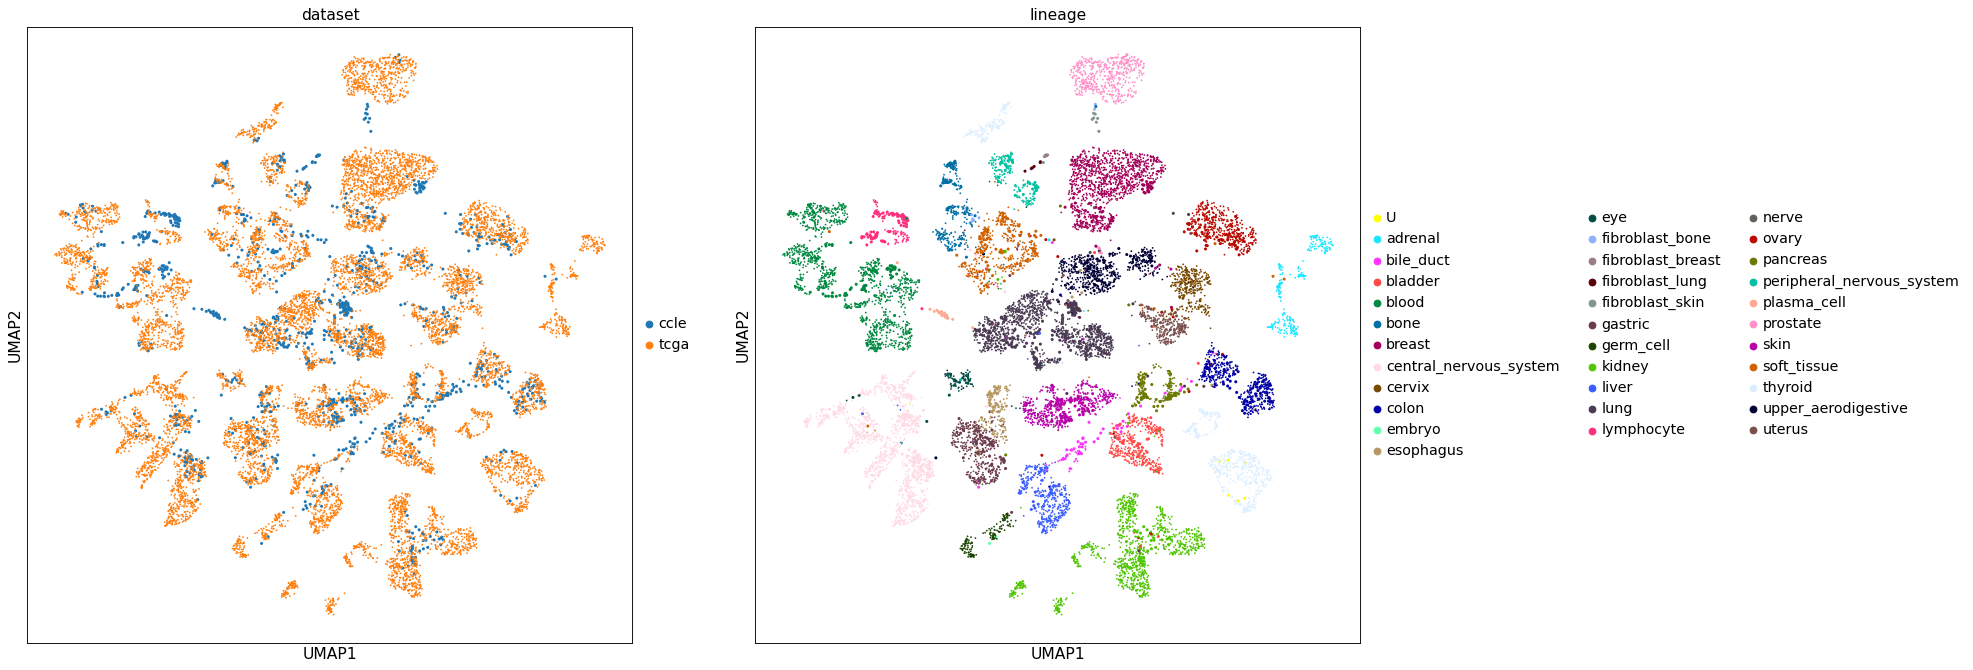

In [357]:
# small with no var genes 
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val !='tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be rem

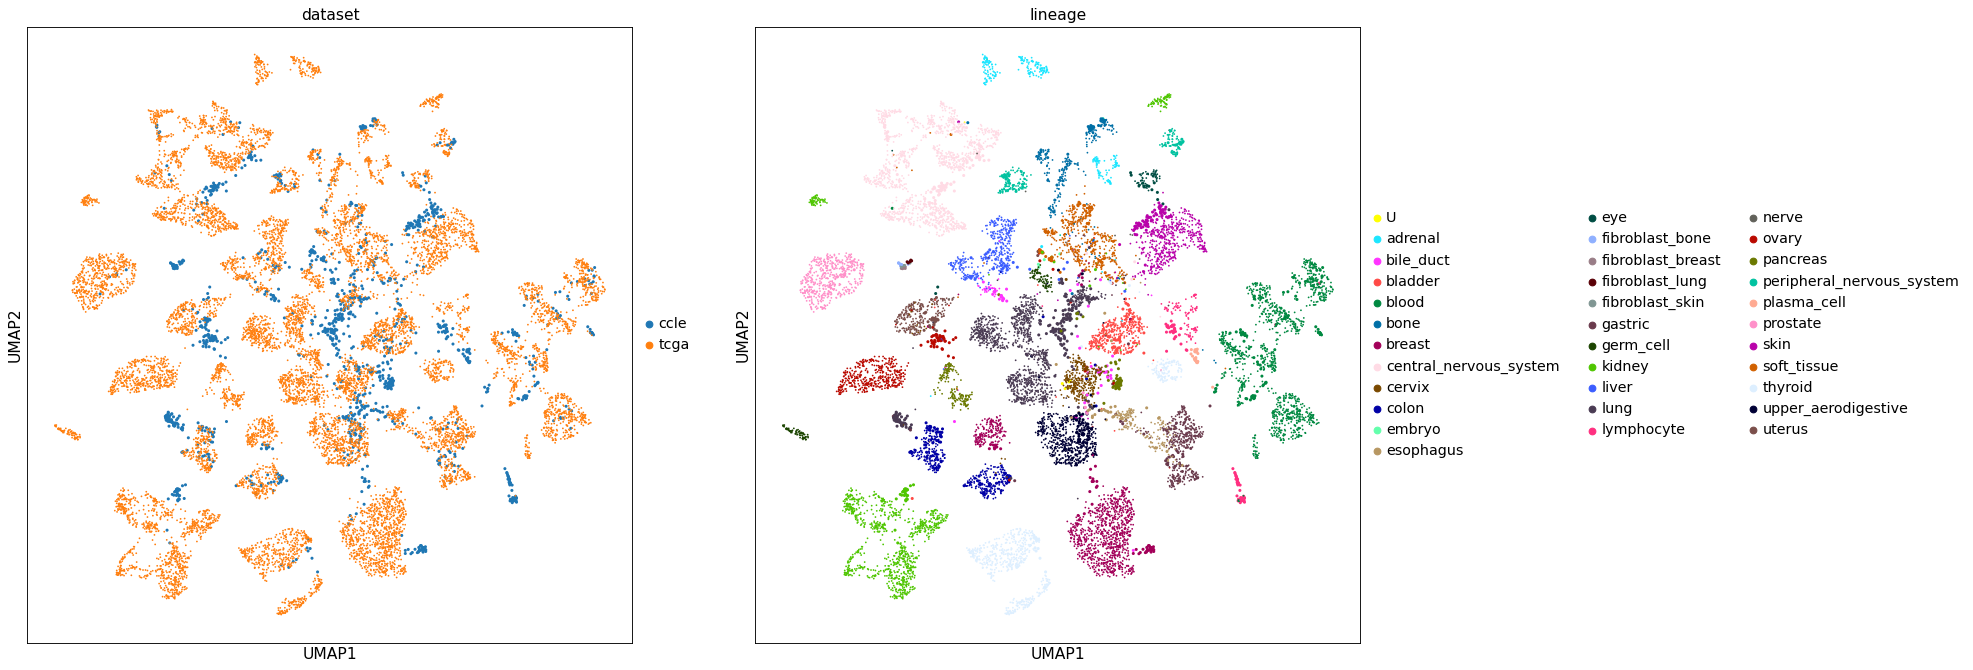

In [311]:
# small with own var genes
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val !='tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

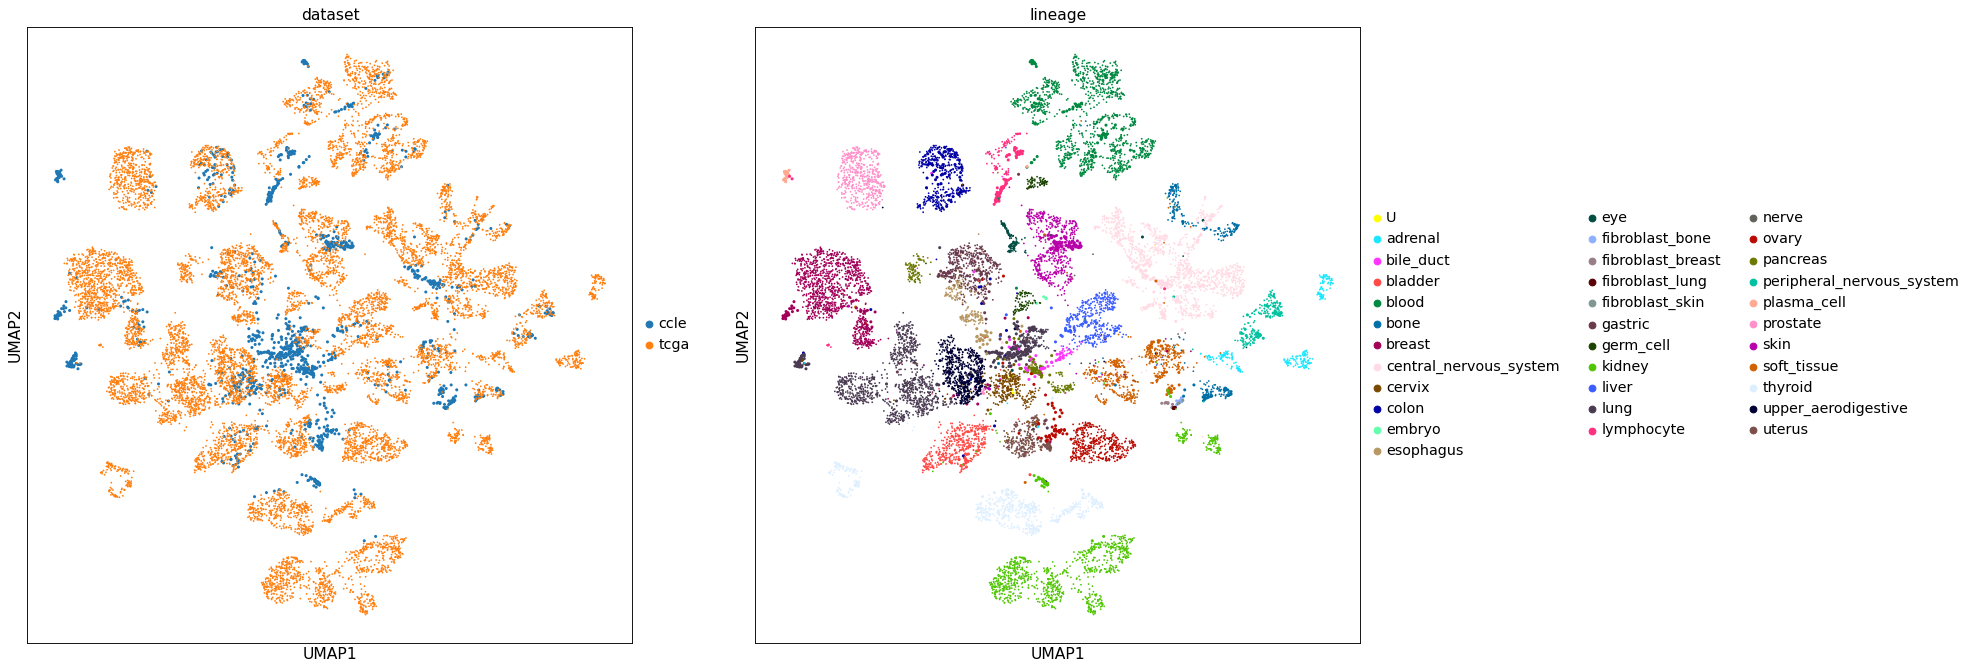

In [281]:
# original small
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [30 if val !='tcga' else 10 for val in evaluator.adata_latent.obs['dataset']])

## zenodo upload / download

In [ ]:
ACCESS_TOKEN = "YOURTOKEN"
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='Celligner2',
                                             description='test CL2 upload',
                                             creators=[
                                                 {"name": "Jeremie, Kalfon", 
                                                  "affiliation": "Broad Institute", 
                                                  "orcid": ""},
                                             ]
                                             )

In [ ]:
download_link = sca.zenodo.upload_model('./model/cl2',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='CL2')

In [ ]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

In [ ]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)
new_cl2 = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)